This file is part of GaPSE
Copyright (C) 2022 Matteo Foglieni

GaPSE is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

GaPSE is distributed in the hope that it will be useful, but
WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU
General Public License for more details.

You should have received a copy of the GNU General Public License
along with GaPSE. If not, see <http://www.gnu.org/licenses/>.
```


```

# ARTICLE

This ipynb provides the code necessary to compute 
- the Power Spectrum (PS) of the Local Primordial Non-Gaussianities (PNG);
- the Power Spectrum made by the sum of 25 General Relativistic (GR) effects arising from the relativistic Galaxy Number Counts (GNC);
- the Power Spectra of the standard Newtonian (the leading GR effect) and of the Galaxies in the Plane-Parallel (PP) approximation.

The PNG are described in the $f_{\rm NL}$ prescription, where the primordial gravitational potential during the matter domination $\Phi_{\rm NG}(s)$ includes a quadratic correction:

$$ \Phi_{\rm NG}(s) = \phi_{\rm G}(s) + f_{\rm NL} \left[ \phi^2_G(s) - \phi^2_{\rm G}(s)\right]$$


where $\phi_{\rm G}$ indicates the primordial potential assumed to be a Gaussian random field, $\langle ...\rangle$ denotes ensemble average and $f_{\rm NL}$ describes the amplitude of the correction.


All the output files will be placed in the following directory:

In [1]:
DIR = "ARTICLE/";

ps_kwargs(alg::Symbol = :fftlog) = alg == :twofast ?
    Dict(
        :alg => :twofast, :epl => true, :pr => false, 
        :N_left => 12, :N_right => 12,
        :p0_left => [-2.0, 1.0], :p0_right => [-2.0, 1.0],
        :int_s_min => 1e0, :int_s_max => 1200.0,
        :cut_first_n=>0, :cut_last_n => 0
    ) : alg == :fftlog ?
    Dict(
        :alg => :fftlog, :pr=>true, :ν => 1.5, 
        :n_extrap_low => 300, :n_extrap_high => 300, 
        :n_pad => 500, :cut_first_n=>0, :cut_last_n => 0,
    ) : throw(AssertionError("alg = :fftlog (recommended) or alg = :twofast !"));
tf = :fftlog;

## Basic Framework

### Definition of a Cosmology

In [2]:
PATH_TO_GAPSE = "../";

In [3]:
include(PATH_TO_GAPSE * "src/GaPSE.jl");

In [4]:
using DelimitedFiles, Plots, Dierckx, SpecialFunctions, TwoFAST, ProgressMeter
using Printf, LaTeXStrings, GridInterpolations, LegendrePolynomials #, StatsPlots, Turing

In [5]:
FILE_F_MAP =  PATH_TO_GAPSE * "data/F_REFERENCE_pi2.txt";
#=
kwargs_map_F_hcub = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-10, 
     :rtol => 1e-2, :atol => 1e-3, :pr => true,
);

kwargs_map_F_trap = Dict(
     :θ_max => π / 2.0, :tolerance => 1e-10, 
     :N => 1000, :pr => true,
);

xs = [x for x in 0:0.02:5]
μs = union(
    [μ for μ in range(-1.0, -0.98, length = 50)], 
    [μ for μ in range(-0.98, 0.98, length = 102)],
    [μ for μ in range(0.98, 1.0, length = 50)]);
GaPSE.print_map_F(FILE_F_MAP, xs, μs; 
    alg = :trap, Fmap_opts = kwargs_map_F_trap # we recommend to use :trap
    #alg = :hcub, Fmap_opts = kwargs_map_F_hcub # but you can use also :hcub if you prefer
)
=#

In [6]:
z_min, z_max, θ_max = 1.0, 1.5, π / 2.0

FILE_BACKGROUND = PATH_TO_GAPSE * "data/WideA_ZA_background.dat";

#=
WFI_opts = Dict(
    :llim => nothing, :rlim => nothing, 
    :rtol => 1e-2, :atol => 0.0, 
    :N => 1000, :pr => true,
)
=#

params = GaPSE.CosmoParams(z_min, z_max, θ_max;
    Ω_b = 0.0489, Ω_cdm = 0.251020, h_0 = 0.70, s_lim=1e-2,
    s_b = 0.0, 𝑓_evo = 0.0, b = 1.5,
    IPS_opts = Dict(
        :fit_left_min => 1e-6, :fit_left_max => 3e-6,
        :fit_right_min => 1e1, :fit_right_max => 2e1),
    IPSTools_opts = Dict(
        :N => 1024, :fit_min => 0.05, :fit_max => 0.5, 
        :con => true, :k_min => 1e-8, :k_max => 10.0),
    #=
    WFI_opts = Dict(
        :llim => nothing, :rlim => nothing, 
        :rtol => 1e-2, :atol => 0.0, 
        :N => 1000, :pr => true,)
    =#
);

In [7]:
#FILE_F_MAP = PATH_TO_GAPSE*"data/F_REFERENCE_pi2.txt";
FILE_IF_MAP = PATH_TO_GAPSE*"data/IntegrF_REFERENCE_pi2_z115.txt";

#=
calc_μs = union(
    [μ for μ in range(-1.0, -0.98, length = 50)], 
    [μ for μ in range(-0.98, 0.98, length = 102)],
    [μ for μ in range(0.98, 1.0, length = 50)]);

GaPSE.print_map_IntegratedF(
    z_min, z_max, calc_μs,
    FILE_F_MAP, FILE_IF_MAP, 
    FILE_BACKGROUND;
    alg = :trap, N_ss = 200, m = 2.1,
    Dict(
        :llim => nothing, :rlim => nothing, 
        :rtol => 1e-2, :atol => 0.0, 
        :N => 1000, :pr => true,
    )...
)
=#

In [8]:
FILE_PS = PATH_TO_GAPSE * "test/datatest/file_pk.txt";
cosmo = GaPSE.Cosmology(params, FILE_BACKGROUND, FILE_PS, FILE_F_MAP, FILE_IF_MAP);

GaPSE.parameters_used(stdout, cosmo)

###############
#    GaPSE    #
############### 
#
# The Cosmology considered had the following paremeters:
# 
# - Matter Power Spectrum input file: "../test/datatest/file_pk.txt"
# - Background data input file: "../data/WideA_ZA_background.dat"
# - F window function input file: "../data/F_REFERENCE_pi2.txt"
# - Integrated F window function input file: "../data/IntegrF_REFERENCE_pi2_z115.txt"
#
# - Basic CosmoParams considered: 
#	 z_min = 1.0 	 z_max = 1.5
#	 θ_max = 1.5707963267948966 [rad] 	 h_0 = 0.7
#	 Ω_b = 0.0489 	 Ω_cdm = 0.25102 	 Ω_M0 = 0.29992
#	 b = 1.5 	 f_evo = 0.0 	 s_b = 0.0
#
# - CosmoParams about the Input Power Spectrum: 
#	 fit_left_min = 1.0e-6 	 fit_right_min = 10.0 	 
#	 fit_left_max = 3.0e-6 	 fit_right_max = 20.0 	 
#
# - CosmoParams about the Input Power Spectrum Tools: 
#	 k_max = 10.0 	 fit_max = 0.5 	 N = 1024 	 
#	 con = true 	 k_min = 1.0e-8 	 fit_min = 0.05 	 
#
# - Computed quantities: 
# 	 effective redshift z_eff = 1.2613556177172358 
# 	 comoving s_m

### Check window function F an integrated IF

In [9]:
my_matrix = readdlm(FILE_F_MAP, comments=true)
my_xs = convert(Vector{Float64}, my_matrix[:,1])
my_μs = convert(Vector{Float64}, my_matrix[:,2])
my_Fs = convert(Vector{Float64}, my_matrix[:,3]);
my_F_grid = GridInterpolations.RectangleGrid( unique(my_μs), unique(my_xs))
my_spline_F(x, μ) = GridInterpolations.interpolate(my_F_grid, my_Fs, [μ, x]);
matrix_Fs = reshape(my_Fs, (length(unique(my_μs)), :))';

In [10]:
my_Imatrix = readdlm(FILE_IF_MAP, comments=true)
my_Iss = convert(Vector{Float64}, my_Imatrix[:,1])
my_Iμs = convert(Vector{Float64}, my_Imatrix[:,2])
my_IFs = convert(Vector{Float64}, my_Imatrix[:,3]);
my_IF_grid = GridInterpolations.RectangleGrid( unique(my_Iμs), unique(my_Iss))
my_spline_IF(s, μ) = GridInterpolations.interpolate(my_IF_grid, my_IFs, [μ, s]);
matrix_IFs = reshape(my_IFs, (length(unique(my_Iμs)), :))';

┌ Warning: backend `PyPlot` is not installed.
└ @ Plots ~/.julia/packages/Plots/Hxe7H/src/backends.jl:37


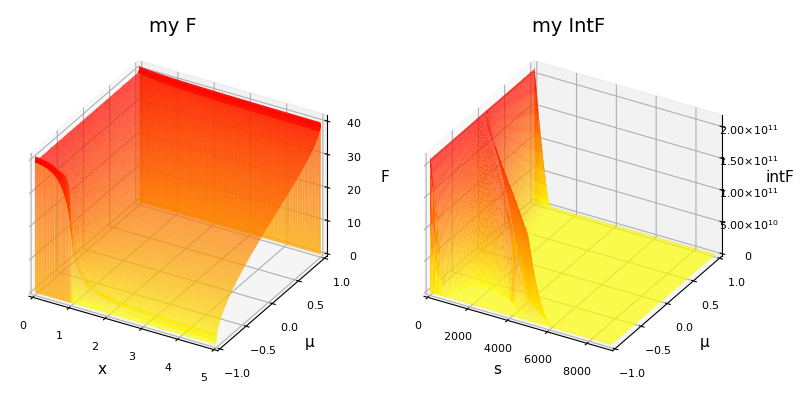

In [11]:
pyplot()
p1 = plot(my_xs, my_μs, my_Fs; xl="x", yl="μ", zl="F", 
    st = :surface, c=cgrad([:yellow, :red]), size=(600, 300), 
    title="my F", legend = false)
p2 = plot(my_Iss, my_Iμs, my_IFs; xl="s", yl="μ", zl="intF", 
    st = :surface, c=cgrad([:yellow, :red]), #size=(600, 300), 
    title="my IntF", legend = false)
p3 = plot(p1, p2, size=(800, 400))

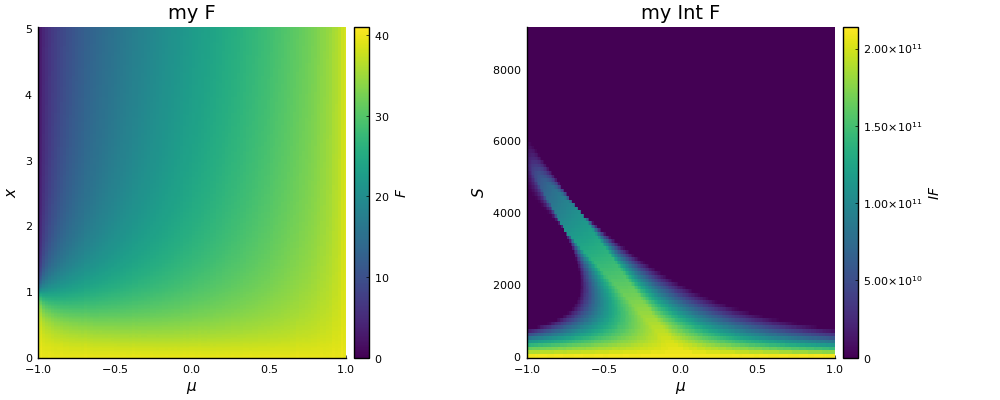

In [12]:
pyplot()

p1 = heatmap(unique(my_μs), unique(my_xs), matrix_Fs, xl=L"$\mu$", yl = L"$x$", colorbar_title=L"$F$", title = "my F")
p2 = heatmap(unique(my_Iμs), unique(my_Iss), matrix_IFs, xl=L"$\mu$", yl = L"$S$", colorbar_title=L"$IF$", title = "my Int F" )

plot(p1, p2, size = (1000, 400))

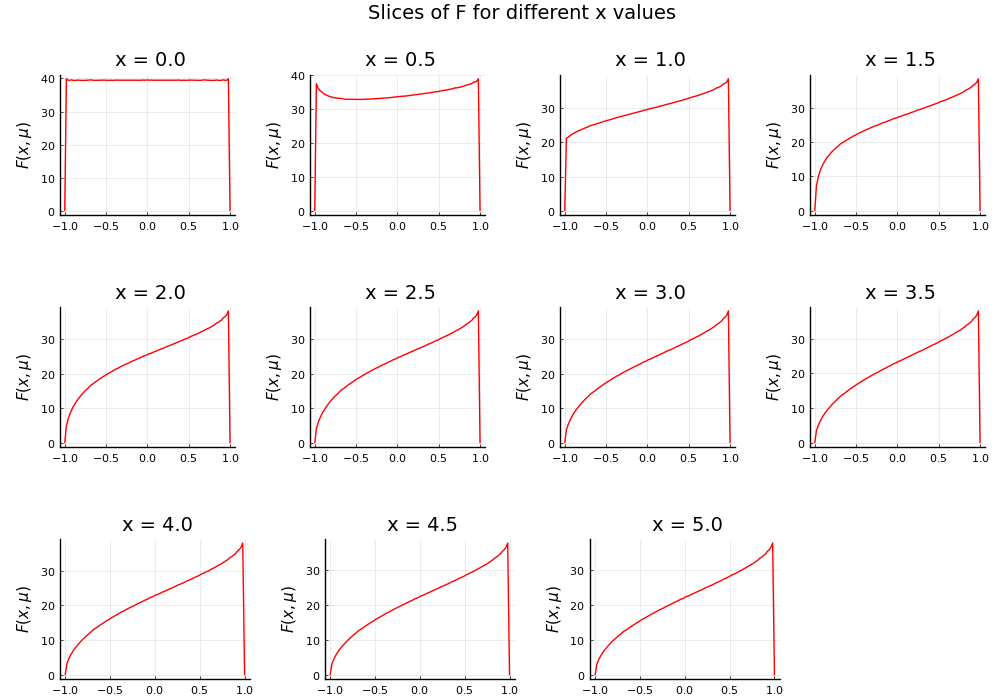

In [13]:
pyplot()

title = plot(title = "Slices of F for different x values", grid=false, 
    showaxis = false, bottom_margin = -25Plots.px, ticks=false)

θ_max =  π/2.0;
xs = [0.0, 0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0];
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(xs)]

for (i,x) in enumerate(xs)
    tit = "\n\n x = $x"
    xs_1 = μs
    ys_1 = [my_spline_F(x, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"F(x,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end


l = @layout [ A{0.003h} ; a b c d ; e f g h ; i l j _]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,700))

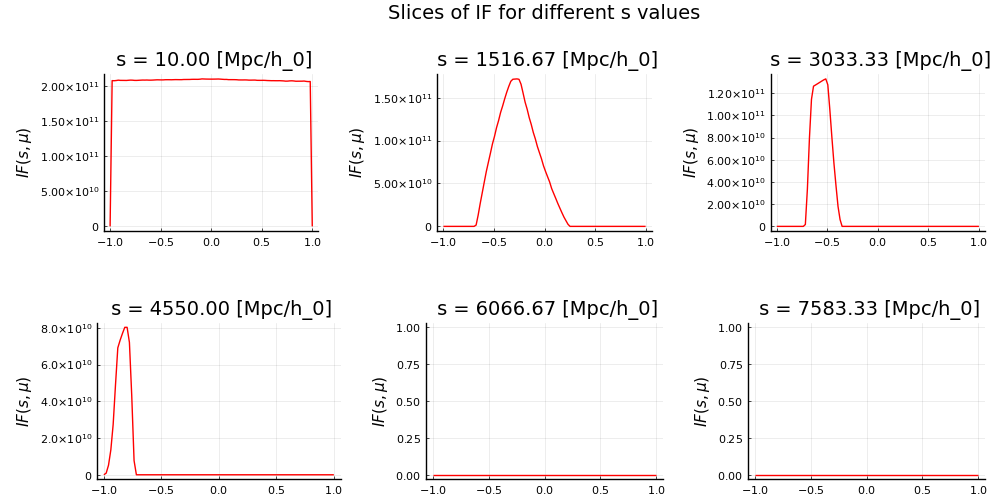

In [14]:
pyplot()

title = plot(title = "Slices of IF for different s values", grid=false, 
    showaxis = false, bottom_margin = -25Plots.px, ticks=false)

θ_max =  π/2.0;
ss = vcat([10.0], [i*max(my_Iss...)/6 for i in 1:5]);
μs = range(-1.0, 1.0, length=100);

LIST_P = [plot() for i in 1:length(ss)]
for (i,s) in enumerate(ss)
    tit = """\n\n s = $(@sprintf("%.2f",s)) [Mpc/h_0]"""
    xs_1 = μs
    ys_1 = [my_spline_IF(s, μ) for μ in xs_1]

    LIST_P[i] = plot(xs_1, ys_1, 
        #xaxis=:log, yaxis=:log, 
        lc=:red, title=tit, legend=false,
        ylabel=L"IF(s,\mu)", ls=:solid, 
        #xticks=10.0 .^ range(-3,0, step=1),
    )
end

l = @layout [ A{0.003h} ; a b c ; d e f ]
ALL_PLOTS = plot(title, LIST_P..., layout=l,
    left_margins = 15Plots.px, right_margins = 15Plots.px, size=(1000,500))

### Definitions of stuff

In [15]:
func_ξs_names = [
    L::Int -> L"$\xi^{\delta \, \delta}_{L=%$L}(s)$", 
    L::Int -> L"$\xi^{v_{\parallel} \, v_{\parallel}}_{L=%$L}(s)$", 
    L::Int -> L"$\xi^{\kappa \, \kappa}_{L=%$L}(s)$", 
    L::Int -> L"$\xi^{\phi \, \phi}_{L=%$L}(s)$", 
    L::Int -> L"$\xi^{\int\phi \, \int\phi}_{L=%$L}(s)$", 
    
    L::Int -> L"$\xi^{\delta \, v_{\parallel}}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{v_{\parallel} \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\delta \, \kappa}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\kappa \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\delta \, \phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\phi \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\delta \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\int\phi \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\kappa \, v_{\parallel}}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{v_{\parallel} \, \kappa}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{v_{\parallel} \, \phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\phi \, v_{\parallel}}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{v_{\parallel} \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\int\phi \, v_{\parallel}}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\kappa \, \phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\phi \, \kappa}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\kappa \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\int\phi \, \kappa}_{L=%$L}(s)$",
    
    L::Int -> L"$\xi^{\phi \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$\xi^{\int\phi \, \phi}_{L=%$L}(s)$",
];

In [16]:
func_ps_names = [
    L::Int -> L"$P^{\delta \, \delta}_{L=%$L}(s)$", 
    L::Int -> L"$P^{v_{\parallel} \, v_{\parallel}}_{L=%$L}(s)$", 
    L::Int -> L"$P^{\kappa \, \kappa}_{L=%$L}(s)$", 
    L::Int -> L"$P^{\phi \, \phi}_{L=%$L}(s)$", 
    L::Int -> L"$P^{\int\phi \, \int\phi}_{L=%$L}(s)$", 
    
    L::Int -> L"$P^{\delta \, v_{\parallel}}_{L=%$L}(s)$",
    L::Int -> L"$P^{v_{\parallel} \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$P^{\delta \, \kappa}_{L=%$L}(s)$",
    L::Int -> L"$P^{\kappa \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$P^{\delta \, \phi}_{L=%$L}(s)$",
    L::Int -> L"$P^{\phi \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$P^{\delta \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$P^{\int\phi \, \delta}_{L=%$L}(s)$",
    
    L::Int -> L"$P^{\kappa \, v_{\parallel}}_{L=%$L}(s)$",
    L::Int -> L"$P^{v_{\parallel} \, \kappa}_{L=%$L}(s)$",
    
    L::Int -> L"$P^{v_{\parallel} \, \phi}_{L=%$L}(s)$",
    L::Int -> L"$P^{\phi \, v_{\parallel}}_{L=%$L}(s)$",
    
    L::Int -> L"$P^{v_{\parallel} \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$P^{\int\phi \, v_{\parallel}}_{L=%$L}(s)$",
    
    L::Int -> L"$P^{\kappa \, \phi}_{L=%$L}(s)$",
    L::Int -> L"$P^{\phi \, \kappa}_{L=%$L}(s)$",
    
    L::Int -> L"$P^{\kappa \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$P^{\int\phi \, \kappa}_{L=%$L}(s)$",
    
    L::Int -> L"$P^{\phi \, \int\phi}_{L=%$L}(s)$",
    L::Int -> L"$P^{\int\phi \, \phi}_{L=%$L}(s)$",
];

## Signal of PNG

### Creation of a CosmoPNG struct

In [17]:
cosmopngparams = GaPSE.CosmoPNGParams(
    cosmo.D_of_s(cosmo.s_eff);
    bf = 1.0, 
    Dict(
        :flm_0 => 5e-2, :flM_0 => 1e-1, :s0_0 => 1e-4,
        :kmin_0 => 1e-6, :kmax_0 => 1e4, :N_0 => 1024,
        :flm_2 => 5e-1, :flM_2 => 1e0, :s0_2 => 1e-4,
        :kmin_2 => 1e-6, :kmax_2 => 1e4, :N_2 => 1024
    )...
);
cosmopng = GaPSE.CosmoPNG(cosmopngparams, cosmo, PATH_TO_GAPSE*"data/Tk.dat");

In [18]:
cosmopng.file_TF

"../data/Tk.dat"

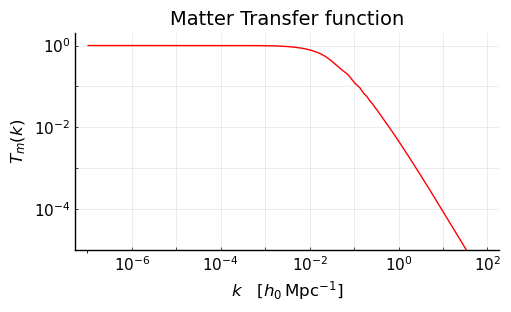

In [19]:
xs_1 = 10.0 .^ range(-7, 2, length=300)
ys_1 = cosmopng.tf.(xs_1)


S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(xs_1, abs.(ys_1),
    xaxis=:log, yaxis=:log, 
    lc=:red, size=(500, 300), ylim=(1e-5, 2e0),
    yticks = (
        [10.0 ^ i for i in -5:0], 
        [i%2==0 ? L"10^{%$i}" : nothing for i in -5:0]),
    xticks = (
        [10.0 ^ i for i in -6:2], 
        [i%2==0 ? L"10^{%$i}" : nothing for i in -6:2]),
    title = "Matter Transfer function",
    ls=:solid, tickfontsize=11, labelfontsize=12,
    ylabel = L"T_m(k)", xlabel = L"k \quad [h_0\, \mathrm{Mpc}^{-1}]",
    legend=false)
savefig(p1, DIR*"Matter_Transfer_Function.pdf");

### S monopole and dipole

In [20]:
ss = 10 .^ range(-3,4; length=300);
J0s = [cosmopng.J0(s) for s in ss]
J2s = [cosmopng.J2(s) for s in ss]
I02s = [cosmo.tools.I02(s) * s^2 for s in ss]; 
I22s = [cosmo.tools.I22(s) * s^2 for s in ss]; 

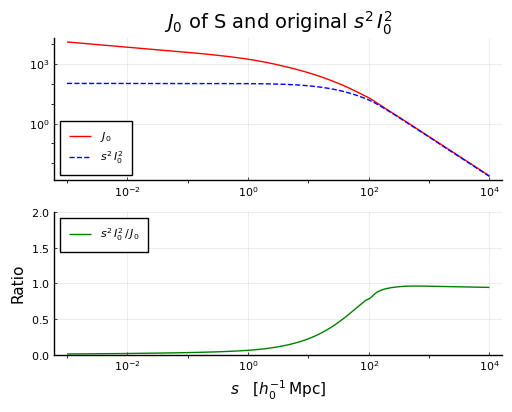

In [21]:
xs_1 = ss
ys_1 = J0s ./ (100 / 299792.458) .^2

xs_2 = ss
ys_2 = I02s
spline_2 = Spline1D(xs_2, ys_2)

#xs_3 = casto_ss
#ys_3 = abs.(casto_J0s) ./ (100 / 299792.458) .^2
#spline_3 = Spline1D(xs_3, ys_3)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"J_0"*" of S and original " * L"s^2 \, I_0^2",
    label=[L"J_0" L"s^2 \, I_0^2"], ls=[:solid :dash], 
    legend=:bottomleft)
#plot!(p1, xs_3, ys_3, label = "casto", ls=:dot)

p2 = plot(xs_1, spline_2.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label = L" s^2 \, I_0^2 \, / \, J_0",
    ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
#plot!(p2, xs_1, spline_3.(xs_1) ./ ys_1, label = "casto / mine")
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )
savefig(P, DIR*"J0_of_S.pdf");

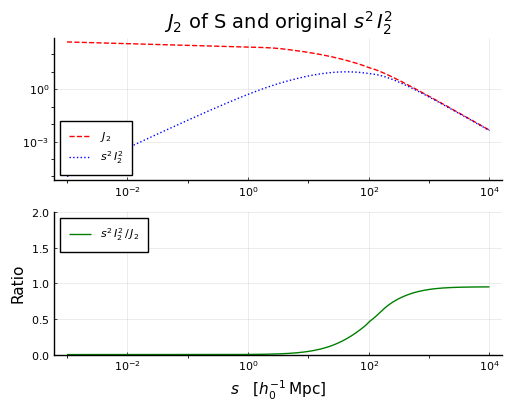

In [22]:
xs_1 = ss
ys_1 = J2s ./ (100 / 299792.458) .^2  #.* 1e13

xs_2 = ss
ys_2 = I22s
spline_2 = Spline1D(xs_2, ys_2)

#xs_3 = casto_ss
#ys_3 = abs.(casto_J2s) ./ (100 / 299792.458) .^2
#spline_3 = Spline1D(xs_3, ys_3)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = L"J_2"*" of S and original " * L"s^2 \, I_2^2",
    label=[L"J_2" L"s^2 \, I_2^2"], ls=[:dash :dot], 
    legend=:bottomleft)
#plot!(p1, xs_3, ys_3, label="casto", ls=:dot)

p2 = plot(xs_1, spline_2.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, label = L"s^2 \, I_2^2 \,  / \, J_2",
    ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
#plot!(p2, xs_1, spline_3.(xs_1) ./ ys_1, label = "casto / mine")
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )
savefig(P, DIR*"J2_of_S.pdf");

### Code for TPCF and PS of S

In [23]:
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "xi_S_L0_noF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=0, use_windows = false);
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "xi_S_L2_noF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=2, use_windows = false);
GaPSE.print_PS_multipole(DIR * "xi_S_L0_noF.dat", 
    DIR * "ps_S_L0_noF.dat"; L = 0, ps_kwargs(tf)...);
GaPSE.print_PS_multipole(DIR * "xi_S_L2_noF.dat", 
    DIR * "ps_S_L2_noF.dat"; L = 2, ps_kwargs(tf)...);


time needed for map_ξ_S_multipole [in s] = 0.03884 

time needed for map_ξ_S_multipole [in s] = 0.03297 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.053978919982910156


I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0006148815155029297



In [24]:
ss_S_L0_noF, xis_S_L0_noF = GaPSE.readxy(DIR * "xi_S_L0_noF.dat");
ss_S_L2_noF, xis_S_L2_noF = GaPSE.readxy(DIR * "xi_S_L2_noF.dat");
ks_S_L0_noF, pks_S_L0_noF = GaPSE.readxy(DIR * "ps_S_L0_noF.dat");
ks_S_L2_noF, pks_S_L2_noF = GaPSE.readxy(DIR * "ps_S_L2_noF.dat");

spline_S_xis_L0_noF = Spline1D(ss_S_L0_noF, xis_S_L0_noF; bc = "error");
spline_S_xis_L2_noF = Spline1D(ss_S_L2_noF, xis_S_L2_noF; bc = "error");
spline_S_pks_L0_noF = Spline1D(ks_S_L0_noF, pks_S_L0_noF; bc = "error");
spline_S_pks_L2_noF = Spline1D(ks_S_L2_noF, pks_S_L2_noF; bc = "error");

In [25]:
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "xi_S_L0_withF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=0, use_windows = true);
GaPSE.print_map_ξ_S_multipole(cosmo, cosmopng, DIR * "xi_S_L2_withF.dat",
    10 .^ range(0, log10(2*cosmo.s_max), length=500); L=2, use_windows = true);
GaPSE.print_PS_multipole(DIR * "xi_S_L0_withF.dat", 
    DIR * "ps_S_L0_withF.dat"; L = 0, ps_kwargs(tf)...);
GaPSE.print_PS_multipole(DIR * "xi_S_L2_withF.dat", 
    DIR * "ps_S_L2_withF.dat"; L = 2, ps_kwargs(tf)...);

ξ_S, L=0: 100%|█████████████████████████████████████████| Time: 0:00:01



time needed for map_ξ_S_multipole [in s] = 2.00493 


ξ_S, L=2: 100%|█████████████████████████████████████████| Time: 0:00:03



time needed for map_ξ_S_multipole [in s] = 3.77285 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0007960796356201172


I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.001750946044921875



In [26]:
ss_S_L0_withF, xis_S_L0_withF = GaPSE.readxy(DIR * "xi_S_L0_withF.dat");
ss_S_L2_withF, xis_S_L2_withF = GaPSE.readxy(DIR * "xi_S_L2_withF.dat");
ks_S_L0_withF, pks_S_L0_withF = GaPSE.readxy(DIR * "ps_S_L0_withF.dat");
ks_S_L2_withF, pks_S_L2_withF = GaPSE.readxy(DIR * "ps_S_L2_withF.dat");

spline_S_xis_L0_withF = Spline1D(ss_S_L0_withF, xis_S_L0_withF; bc = "error");
spline_S_xis_L2_withF = Spline1D(ss_S_L2_withF, xis_S_L2_withF; bc = "error");
spline_S_pks_L0_withF = Spline1D(ks_S_L0_withF, pks_S_L0_withF; bc = "error");
spline_S_pks_L2_withF = Spline1D(ks_S_L2_withF, pks_S_L2_withF; bc = "error");

### Check Plot S multipoles

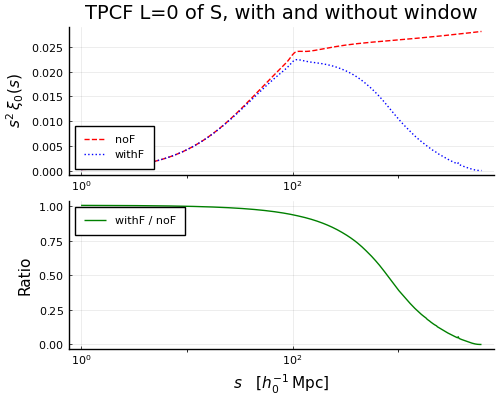

In [27]:
xs_1 = ss_S_L0_noF
ys_1 = xis_S_L0_noF .* xs_1 .^ 2

xs_2 = ss_S_L0_withF 
ys_2 = xis_S_L0_withF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "TPCF L=0 of S, with and without window",
    label=["noF" "withF"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi_0(s)",
    legend=:bottomleft)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "withF / noF",
    #ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )

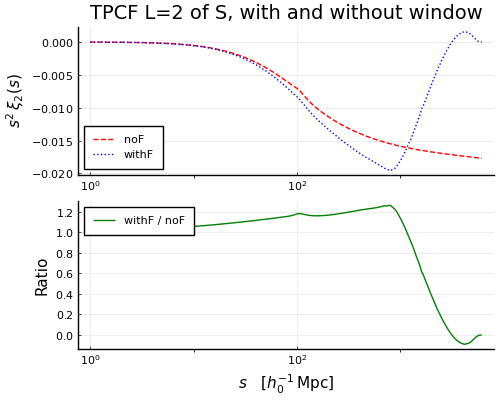

In [28]:
xs_1 = ss_S_L2_noF
ys_1 = xis_S_L2_noF .* xs_1 .^ 2

xs_2 = ss_S_L2_withF 
ys_2 = xis_S_L2_withF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "TPCF L=2 of S, with and without window",
    label=["noF" "withF"], ls=[:dash :dot], 
    ylabel = L"s^2 \, \xi_2(s)",
    legend=:bottomleft)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "withF / noF",
    #ylim=(0,2), 
    legend=:topleft, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
    
P = plot(p1, p2, size=(500, 400), layout= @layout [ x ; y  ] )

## LIST OF GNC EFFECTS THAT CANNOT BE CONFUSED WITH THE PNG SIGNAL

The following list contains all the GNC effects that cannot be confused with the PNG signal al large scales due to the fact that they have a different asymptotic behaviour at large scales.

In [79]:
LIST_GNC_SECURE = [
    "auto_newton", "auto_lensing",  
    
    "lensing_newton", "newton_lensing", 
    "doppler_newton", "newton_doppler", 
    "doppler_lensing", "lensing_doppler",
];

LIST_GNC_NON_SECURE = [
    "auto_doppler", "auto_localgp", "auto_integratedgp",

    "newton_localgp", "localgp_newton",
    "newton_integratedgp", "integratedgp_newton",
    
    "doppler_localgp", "localgp_doppler",
    "doppler_integratedgp", "integratedgp_doppler",
    
    "lensing_localgp", "localgp_lensing",
    "lensing_integratedgp", "integratedgp_lensing",

    "localgp_integratedgp", "integratedgp_localgp",
];


for effect in LIST_GNC_SECURE
    @assert effect in GaPSE.GR_EFFECTS_GNC "1: $effect"
end

for effect in LIST_GNC_NON_SECURE
    @assert effect in GaPSE.GR_EFFECTS_GNC "2: $effect"
end

for effect in LIST_GNC_SECURE
    @assert !(effect in LIST_GNC_NON_SECURE) "3: $effect"
end

for effect in GaPSE.GR_EFFECTS_GNC
    if effect in LIST_GNC_SECURE || effect in LIST_GNC_NON_SECURE
        nothing
    else
        throw(AssertionError("$effect is not included!"))
    end
end

## Computation of the GNC TPCFs and Newtonian TPCF (and their PS)

### Computation of the TPCFs and PS

In [30]:
name_xis_GNC_L0_noF_noobsvel_file = "xis_GNC_L0_noF_noobsvel.txt";
name_ps_GNC_L0_noF_noobsvel_file ="ps_GNC_L0_noF_noobsvel.txt";
name_xis_GNC_L0_noF_noobs_file = "xis_GNC_L0_noF_noobs.txt";
name_ps_GNC_L0_noF_noobs_file ="ps_GNC_L0_noF_noobs.txt";

name_xis_GNC_L0_withF_noobsvel_file = "xis_GNC_L0_withF_noobsvel.txt";
name_ps_GNC_L0_withF_noobsvel_file ="ps_GNC_L0_withF_noobsvel.txt";
name_xis_GNC_L0_withF_noobs_file = "xis_GNC_L0_withF_noobs.txt";
name_ps_GNC_L0_withF_noobs_file ="ps_GNC_L0_withF_noobs.txt";

In [31]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*name_xis_GNC_L0_noF_noobsvel_file, 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    use_windows = false, L = 0, alg = :quad, obs = :noobsvel,
    single = true, enhancer = 1e8,
    N_trap = 200, N_lob = 200, atol_quad = 0.0, rtol_quad = 1e-2, 
    N_χs = 100, N_χs_2 = 60);
=#

In [32]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*name_xis_GNC_L0_withF_noobsvel_file, 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    use_windows = true, L = 0, alg = :quad, obs = :noobsvel,
    single = true, enhancer = 1e8,
    N_trap = 200, N_lob = 200, atol_quad = 0.0, rtol_quad = 1e-2, 
    N_χs = 100, N_χs_2 = 60);
=#

In [33]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*name_xis_GNC_L0_noF_noobs_file,
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    use_windows = false, L = 0, alg = :quad, obs = :no,
    single = true, enhancer = 1e8,
    N_trap = 200, N_lob = 200, atol_quad = 0.0, rtol_quad = 1e-2, 
    N_χs = 100, N_χs_2 = 60);
=#

In [34]:
#=
GaPSE.print_map_sum_ξ_GNC_multipole(
    cosmo, DIR*name_xis_GNC_L0_withF_noobs_file, 
    10 .^ range(0, log10(2*cosmo.s_max), length = 500);
    use_windows = true, L = 0, alg = :quad, obs = :no,
    single = true, enhancer = 1e8,
    N_trap = 200, N_lob = 200, atol_quad = 0.0, rtol_quad = 1e-2, 
    N_χs = 100, N_χs_2 = 60);
=#

In [35]:
ss_GNC_L0_noF_noobsvel, xis_sum_GNC_L0_noF_noobsvel, xis_all_GNC_L0_noF_noobsvel = 
    GaPSE.readxyall(DIR*name_xis_GNC_L0_noF_noobsvel_file);
spline_GNCsum_xis_L0_noF_noobsvel = Spline1D(ss_GNC_L0_noF_noobsvel, xis_sum_GNC_L0_noF_noobsvel; bc = "error");
ss_GNC_L0_noF_noobs, xis_sum_GNC_L0_noF_noobs, xis_all_GNC_L0_noF_noobs = 
    GaPSE.readxyall(DIR*name_xis_GNC_L0_noF_noobs_file);
spline_GNCsum_xis_L0_noF_noobs = Spline1D(ss_GNC_L0_noF_noobs, xis_sum_GNC_L0_noF_noobs; bc = "error");


ss_GNC_L0_withF_noobsvel, xis_sum_GNC_L0_withF_noobsvel, xis_all_GNC_L0_withF_noobsvel = 
    GaPSE.readxyall(DIR*name_xis_GNC_L0_withF_noobsvel_file);
spline_GNCsum_xis_L0_withF_noobsvel = Spline1D(ss_GNC_L0_withF_noobsvel, xis_sum_GNC_L0_withF_noobsvel; bc = "error");
ss_GNC_L0_withF_noobs, xis_sum_GNC_L0_withF_noobs, xis_all_GNC_L0_withF_noobs = 
    GaPSE.readxyall(DIR*name_xis_GNC_L0_withF_noobs_file);
spline_GNCsum_xis_L0_withF_noobs = Spline1D(ss_GNC_L0_withF_noobs, xis_sum_GNC_L0_withF_noobs; bc = "error");

In [36]:
GaPSE.print_all_PS_multipole(DIR*name_xis_GNC_L0_noF_noobsvel_file, 
    DIR*name_ps_GNC_L0_noF_noobsvel_file, "GNC"; L=0, ps_kwargs(tf)...)
ks_GNC_L0_noF_noobsvel, pks_sum_GNC_L0_noF_noobsvel, pks_all_GNC_L0_noF_noobsvel = 
    GaPSE.readxyall(DIR*name_ps_GNC_L0_noF_noobsvel_file);
spline_GNCsum_pks_L0_noF_noobsvel = Spline1D(ks_GNC_L0_noF_noobsvel, pks_sum_GNC_L0_noF_noobsvel; bc = "error");

GaPSE.print_all_PS_multipole(DIR*name_xis_GNC_L0_noF_noobs_file, 
    DIR*name_ps_GNC_L0_noF_noobs_file, "GNC"; L=0, ps_kwargs(tf)...)
ks_GNC_L0_noF_noobs, pks_sum_GNC_L0_noF_noobs, pks_all_GNC_L0_noF_noobs = 
    GaPSE.readxyall(DIR*name_ps_GNC_L0_noF_noobs_file);
spline_GNCsum_pks_L0_noF_noobs = Spline1D(ks_GNC_L0_noF_noobs, pks_sum_GNC_L0_noF_noobs; bc = "error");

GaPSE.print_all_PS_multipole(DIR*name_xis_GNC_L0_withF_noobsvel_file, 
    DIR*name_ps_GNC_L0_withF_noobsvel_file, "GNC"; L=0, ps_kwargs(tf)...)
ks_GNC_L0_withF_noobsvel, pks_sum_GNC_L0_withF_noobsvel, pks_all_GNC_L0_withF_noobsvel = 
    GaPSE.readxyall(DIR*name_ps_GNC_L0_withF_noobsvel_file);
spline_GNCsum_pks_L0_withF_noobsvel = Spline1D(ks_GNC_L0_withF_noobsvel, pks_sum_GNC_L0_withF_noobsvel; bc = "error");

GaPSE.print_all_PS_multipole(DIR*name_xis_GNC_L0_withF_noobs_file, 
    DIR*name_ps_GNC_L0_withF_noobs_file, "GNC"; L=0, ps_kwargs(tf)...)
ks_GNC_L0_withF_noobs, pks_sum_GNC_L0_withF_noobs, pks_all_GNC_L0_withF_noobs = 
    GaPSE.readxyall(DIR*name_ps_GNC_L0_withF_noobs_file);
spline_GNCsum_pks_L0_withF_noobs = Spline1D(ks_GNC_L0_withF_noobs, pks_sum_GNC_L0_withF_noobs; bc = "error");


I'm computing the PS_multipole from the file "ARTICLE/xis_GNC_L0_noF_noobsvel.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.16849184036254883


I'm computing the PS_multipole from the file "ARTICLE/xis_GNC_L0_noF_noobs.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.03423905372619629


I'm computing the PS_multipole from the file "ARTICLE/xis_GNC_L0_withF_noobsvel.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.033232927322387695


I'm computing the PS_multipole from the file "ARTICLE/xis_GNC_L0_withF_noobs.txt"for the Galaxy Number Counts.

time needed for all the Power Spectra computation [in s] = 0.033132076263427734



In [37]:
ks_Newtonian_L0_withF_noobsvel, pks_Newtonian_L0_withF_noobsvel = 
    ks_GNC_L0_withF_noobsvel, pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]];
spline_Newt_pks_L0_withF_noobsvel = Spline1D(ks_Newtonian_L0_withF_noobsvel, pks_Newtonian_L0_withF_noobsvel; bc = "error");
ks_Newtonian_L0_withF_noobs, pks_Newtonian_L0_withF_noobs = 
    ks_GNC_L0_withF_noobs, pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]];
spline_Newt_pks_L0_withF_noobs = Spline1D(ks_Newtonian_L0_withF_noobs, pks_Newtonian_L0_withF_noobs; bc = "error");

In [38]:
pks_PARTIAL_GNC_L0_withF_noobsvel = zeros(length(pks_sum_GNC_L0_withF_noobsvel))
pks_PARTIAL_GNC_L0_withF_noobsvel += pks_sum_GNC_L0_withF_noobsvel
for effect in GaPSE.GR_EFFECTS_GNC
    if effect in LIST_GNC_SECURE
        pks_PARTIAL_GNC_L0_withF_noobsvel .-= pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC[effect]]
    end
end
spline_GNCsumPARTIAL_pks_L0_withF_noobsvel = Spline1D(ks_GNC_L0_withF_noobsvel, pks_PARTIAL_GNC_L0_withF_noobsvel; bc = "error");

pks_PARTIAL_GNC_L0_withF_noobs = zeros(length(pks_sum_GNC_L0_withF_noobs))
pks_PARTIAL_GNC_L0_withF_noobs += pks_sum_GNC_L0_withF_noobs
for effect in GaPSE.GR_EFFECTS_GNC
    if effect in LIST_GNC_SECURE
        pks_PARTIAL_GNC_L0_withF_noobs .-= pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC[effect]]
    end
end
spline_GNCsumPARTIAL_pks_L0_withF_noobs = Spline1D(ks_GNC_L0_withF_noobs, pks_PARTIAL_GNC_L0_withF_noobs; bc = "error");

### Check Plots of the GNC and Newtonian TPCFs and PS

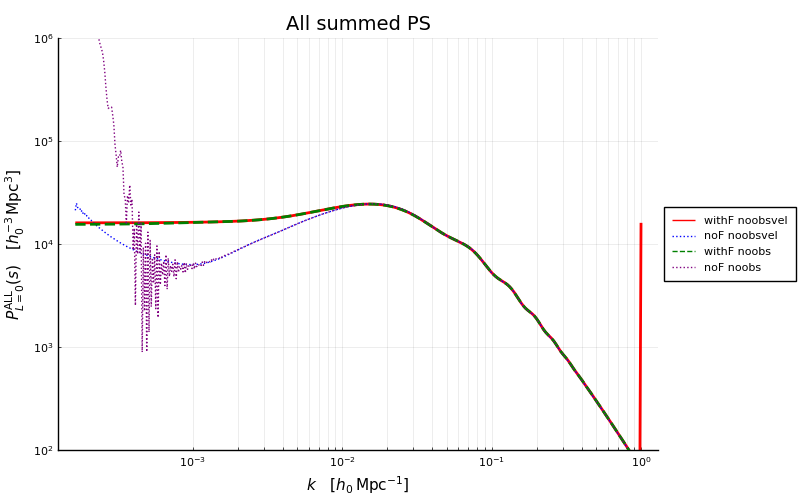

In [39]:
xs_1 = ks_GNC_L0_withF_noobsvel
xs_2 = ks_GNC_L0_noF_noobsvel
xs_3 = ks_GNC_L0_withF_noobs
xs_4 = ks_GNC_L0_noF_noobs

p = plot(
        xs_1[pks_sum_GNC_L0_withF_noobsvel.≠0], 
        abs.(pks_sum_GNC_L0_withF_noobsvel)[xis_sum_GNC_L0_withF_noobsvel.≠0], 
        size=(800, 500), axis = :log, label="withF noobsvel",
        lw=2, lc="red", ls=:solid,
        yticks = 10.0 .^ [i for i in -6:1:6], ylims = (1e2, 1e6),
        xticks = (
            vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
            vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
        ),
        title="All summed PS", 
        xlabel=L"k \quad [h_0 \,\mathrm{Mpc}^{-1}]",
        ylabel=L"P^{\mathrm{ALL}}_{L=0}(s)  \quad [h_0^{-3} \,\mathrm{Mpc}^3] ",
        #xaxis=:log, #yaxis=:log,
        top_margins=15Plots.px, legend=:outerright)
plot!(p, xs_2[pks_sum_GNC_L0_noF_noobsvel.≠0], 
    abs.(pks_sum_GNC_L0_noF_noobsvel)[pks_sum_GNC_L0_noF_noobsvel.≠0], 
    lw=1, lc="blue", ls=:dot, label="noF noobsvel")
plot!(p, xs_3[pks_sum_GNC_L0_withF_noobs.≠0], 
    abs.(pks_sum_GNC_L0_withF_noobs)[pks_sum_GNC_L0_withF_noobs.≠0], 
    lw=2, lc="green", ls=:dash, label="withF noobs")
plot!(p, xs_4[pks_sum_GNC_L0_noF_noobs.≠0], 
    abs.(pks_sum_GNC_L0_noF_noobs)[pks_sum_GNC_L0_noF_noobs.≠0], 
    lw=1, lc="purple", ls=:dot, label="noF noobs")

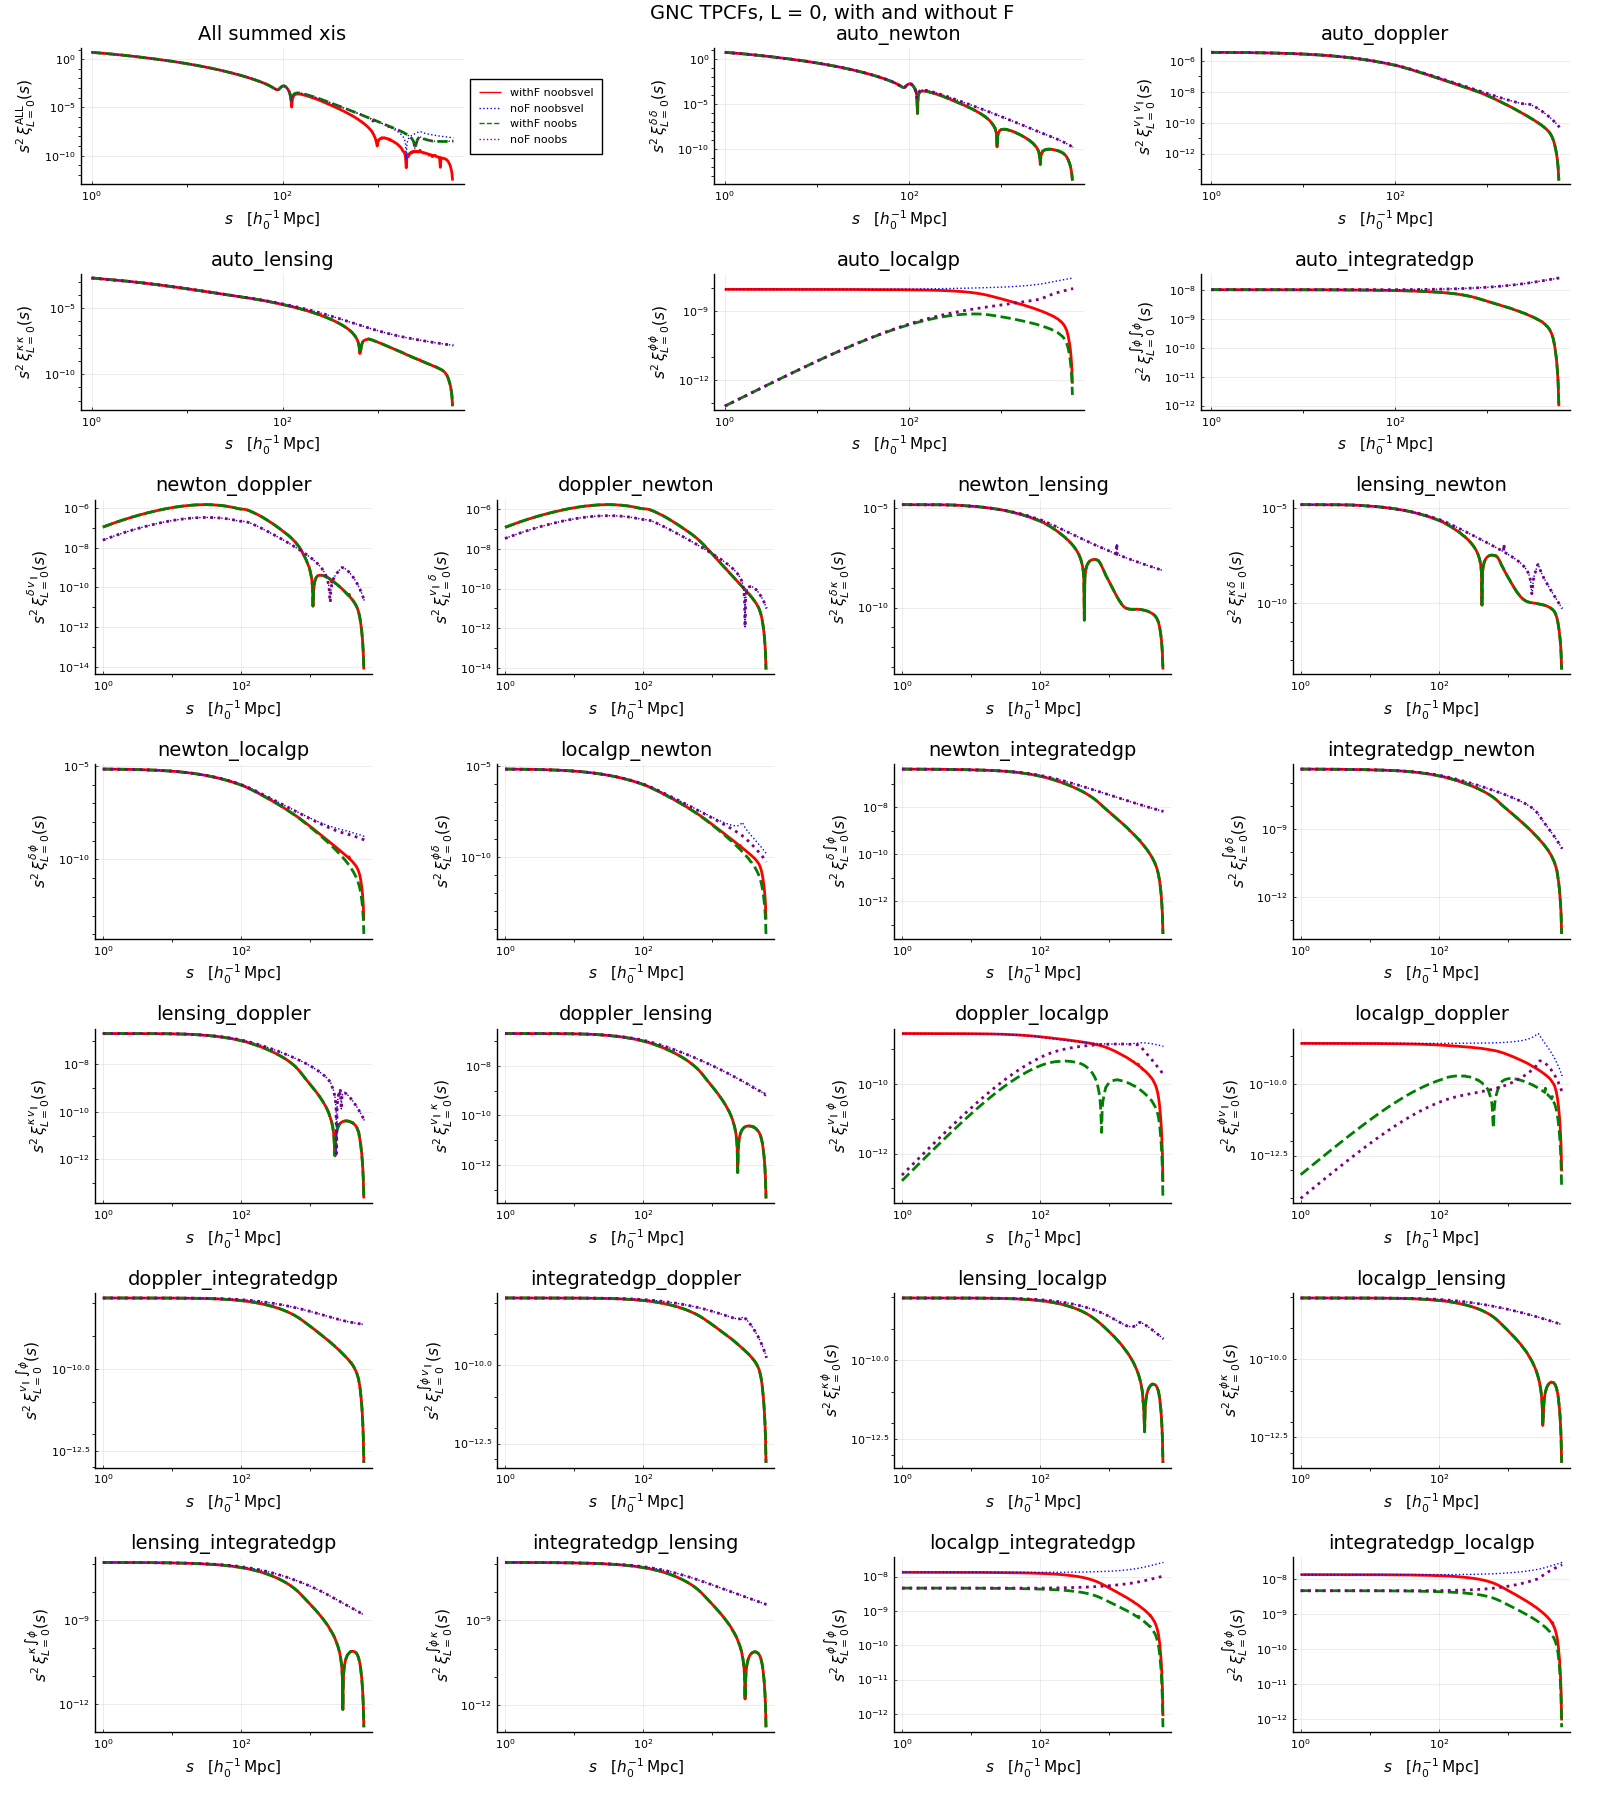

In [40]:
pyplot()
ps = [plot() for i in 1:length(GaPSE.GR_EFFECTS_GNC) + 1]

title = plot(title = "GNC TPCFs, L = 0, with and without F", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

legend_pos=[
    :bottomleft,
    :bottomleft, :topright, :bottomleft, :bottomleft,
    :topleft, :topleft, :topleft, :topleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]

xs_1 = ss_GNC_L0_withF_noobsvel
xs_2 = ss_GNC_L0_noF_noobsvel
xs_3 = ss_GNC_L0_withF_noobs
xs_4 = ss_GNC_L0_noF_noobs

ps[1] = plot(xs_1[xis_sum_GNC_L0_withF_noobsvel.≠0], 
        abs.(xis_sum_GNC_L0_withF_noobsvel)[xis_sum_GNC_L0_withF_noobsvel.≠0], size=(300, 100),
        lw=2, lc="red", ls=:solid, label="withF noobsvel",
        title="All summed xis", 
        xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
        ylabel=L"s^2 \, \xi^{\mathrm{ALL}}_{L=0}(s)",
        xaxis=:log, yaxis=:log,
        top_margins=15Plots.px, legend=:outerright)
plot!(ps[1], xs_2, abs.(xis_sum_GNC_L0_noF_noobsvel), 
    lw=1, lc="blue", ls=:dot, label="noF noobsvel")
plot!(ps[1], xs_3, abs.(xis_sum_GNC_L0_noF_noobs), 
    lw=2, lc="green", ls=:dash, label="withF noobs")
plot!(ps[1], xs_4, abs.(xis_sum_GNC_L0_noF_noobs), 
    lw=1, lc="purple", ls=:dot, label="noF noobs")

for (i, name) in enumerate(GaPSE.GR_EFFECTS_GNC)
    ys_1 = xis_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC[name]]
    ys_2 = xis_all_GNC_L0_noF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC[name]]
    ys_3 = xis_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC[name]]
    ys_4 = xis_all_GNC_L0_noF_noobs[GaPSE.INDEX_GR_EFFECT_GNC[name]]

    ps[i+1] = plot(
        xs_1[ys_1.≠0], abs.(ys_1)[ys_1.≠0], 
        size=(300, 100),
        lw=2, lc="red", ls=:solid, label="withF",
        title=name, 
        xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
        ylabel=L"s^2 \, " * func_ξs_names[GaPSE.INDEX_GR_EFFECT_GNC[name]](0),
        xaxis=:log, yaxis=:log,
        top_margins=15Plots.px,
        legend = false,
    )
    plot!(ps[i+1], xs_2[ys_2.≠0], abs.(ys_2)[ys_2.≠0], 
        lw=1, lc="blue", ls=:dot, label="noF noobsvel")
    plot!(ps[i+1], xs_3[ys_3.≠0], abs.(ys_3)[ys_3.≠0], 
        lw=2, lc="green", ls=:dash, label="withF noobs")
    plot!(ps[i+1], xs_4[ys_4.≠0], abs.(ys_4)[ys_4.≠0], 
        lw=2, lc="purple", ls=:dot, label="noF noobsvel")
end

l = @layout [A{0.02h}; grid(2,3){0.22h} ; grid(5,4){0.75h} ]
P = plot(title, ps..., layout=l, 
    left_margins = 15Plots.px, right_margins = 30Plots.px,
    size=(1600,1800));
P

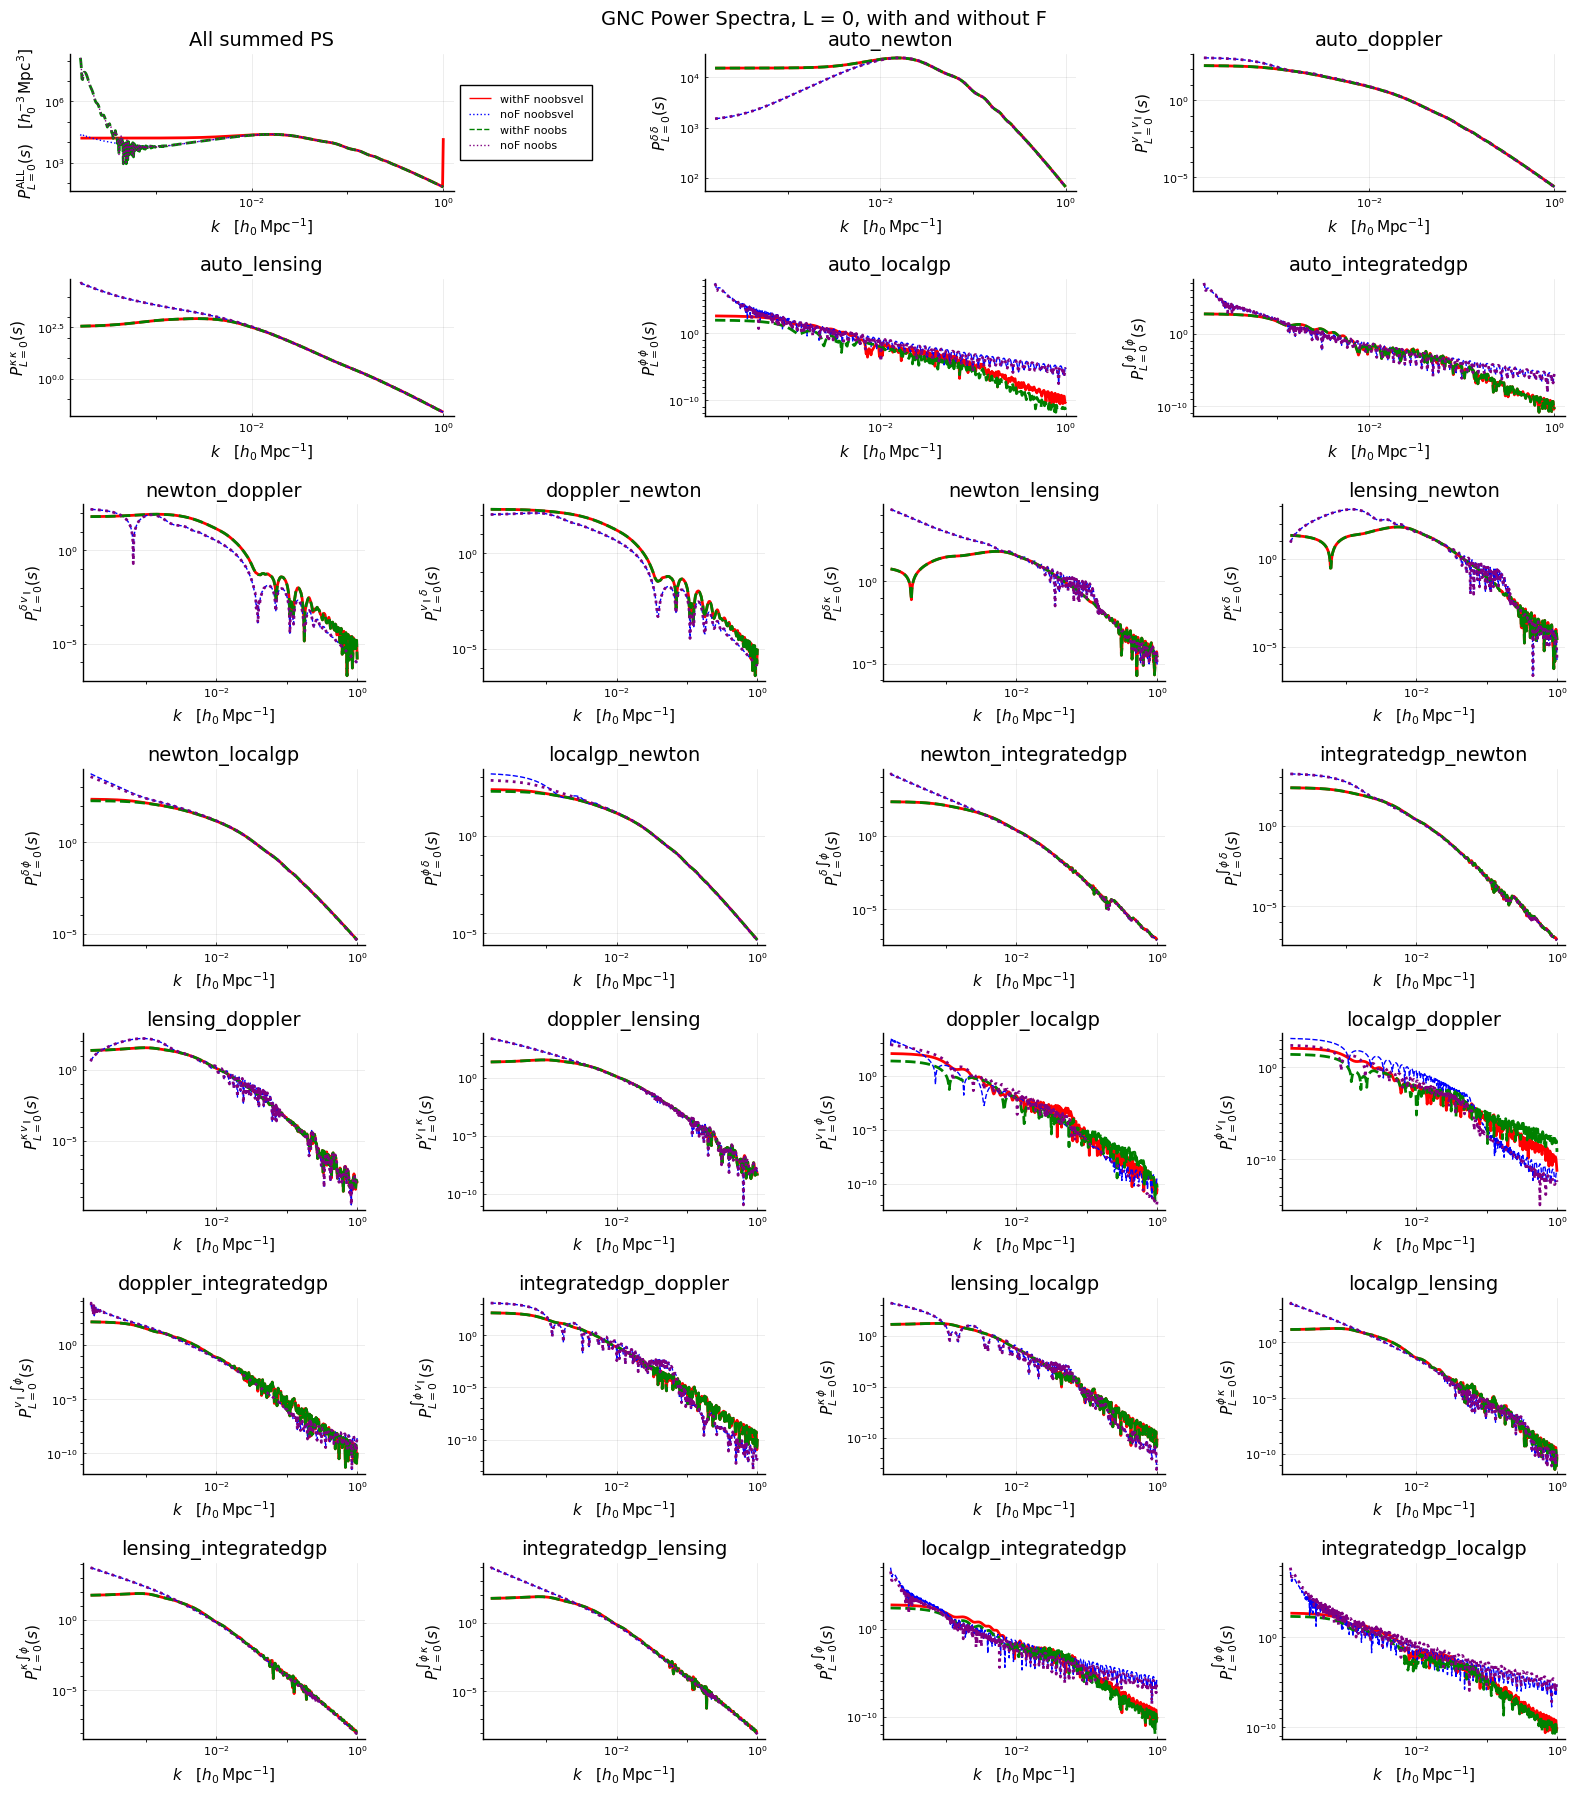

In [41]:
pyplot()
ps = [plot() for i in 1:length(GaPSE.GR_EFFECTS_GNC) + 1]

title = plot(title = "GNC Power Spectra, L = 0, with and without F", grid=false, 
    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

legend_pos=[
    :bottomleft,
    :bottomleft, :topright, :bottomleft, :bottomleft,
    :topleft, :topleft, :topleft, :topleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]

xs_1 = ks_GNC_L0_withF_noobsvel
xs_2 = ks_GNC_L0_noF_noobsvel
xs_3 = ks_GNC_L0_withF_noobs
xs_4 = ks_GNC_L0_noF_noobs

ps[1] = plot(
        xs_1[pks_sum_GNC_L0_withF_noobsvel.≠0], 
        abs.(pks_sum_GNC_L0_withF_noobsvel)[xis_sum_GNC_L0_withF_noobsvel.≠0], 
        size=(300, 100), axis = :log, label="withF noobsvel",
        lw=2, lc="red", ls=:solid,
        title="All summed PS", 
        xlabel=L"k \quad [h_0 \,\mathrm{Mpc}^{-1}]",
        ylabel=L"P^{\mathrm{ALL}}_{L=0}(s)  \quad [h_0^{-3} \,\mathrm{Mpc}^3] ",
        #xaxis=:log, #yaxis=:log,
        top_margins=15Plots.px, legend=:outerright)
plot!(ps[1], xs_2[pks_sum_GNC_L0_noF_noobsvel.≠0], 
    abs.(pks_sum_GNC_L0_noF_noobsvel)[pks_sum_GNC_L0_noF_noobsvel.≠0], 
    lw=1, lc="blue", ls=:dot, label="noF noobsvel")
plot!(ps[1], xs_3[pks_sum_GNC_L0_noF_noobs.≠0], 
    abs.(pks_sum_GNC_L0_noF_noobs)[pks_sum_GNC_L0_noF_noobs.≠0], 
    lw=2, lc="green", ls=:dash, label="withF noobs")
plot!(ps[1], xs_4[pks_sum_GNC_L0_noF_noobs.≠0], 
    abs.(pks_sum_GNC_L0_noF_noobs)[pks_sum_GNC_L0_noF_noobs.≠0], 
    lw=1, lc="purple", ls=:dot, label="noF noobs")

for (i, name) in enumerate(GaPSE.GR_EFFECTS_GNC)
    ys_1 = pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC[name]]
    ys_2 = pks_all_GNC_L0_noF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC[name]]
    ys_3 = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC[name]]
    ys_4 = pks_all_GNC_L0_noF_noobs[GaPSE.INDEX_GR_EFFECT_GNC[name]]

    ps[i+1] = plot(
        xs_1[ys_1.≠0], abs.(ys_1)[ys_1.≠0], 
        size=(300, 100), axis = :log, label="withF noobsvel",
        lw=2, lc="red", ls=:solid,
        title=name, 
        xlabel=L"k \quad [h_0 \,\mathrm{Mpc}^{-1}]",
        ylabel=func_ps_names[GaPSE.INDEX_GR_EFFECT_GNC[name]](0),
        #xaxis=:log, #yaxis=:log,
        top_margins=15Plots.px,
        legend = false,
    )
    plot!(ps[i+1], xs_2[ys_2.≠0], abs.(ys_2)[ys_2.≠0], 
        lw=1, lc="blue", ls=:dash, label="noF noobsvel")
    plot!(ps[i+1], xs_3[ys_3.≠0], abs.(ys_3)[ys_3.≠0], 
        lw=2, lc="green", ls=:dash, label="withF noobs")
    plot!(ps[i+1], xs_4[ys_4.≠0], abs.(ys_4)[ys_4.≠0], 
        lw=2, lc="purple", ls=:dot, label="noF noobs")
end

l = @layout [A{0.02h}; grid(2,3){0.22h} ; grid(5,4){0.75h} ]
P = plot(title, ps..., layout=l, 
    left_margins = 15Plots.px, right_margins = 30Plots.px,
    size=(1600,1800));
savefig(P, DIR*"ps_GNC_L0_with-withoutF_noobsvel.pdf");

### Check major Contributors to GNC

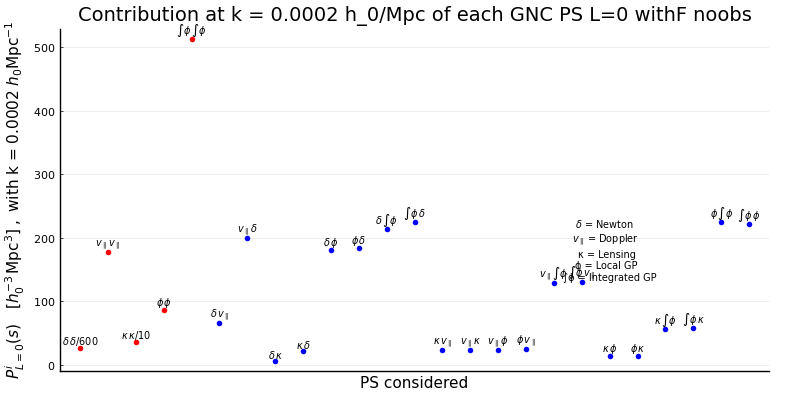

sys:1: UserWarning: No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


In [42]:
names = [
    L"\delta \, \delta / 600", 
    L"v_{\parallel} \, v_{\parallel}", 
    L"\kappa \, \kappa / 10", 
    L"\phi \, \phi", 
    L"\int\phi \, \int\phi", 
    
    L"\delta \, v_{\parallel}", L"v_{\parallel} \, \delta",
    L"\delta \, \kappa", L"\kappa \, \delta",
    L"\delta \, \phi", L"\phi \, \delta",
    L"\delta \, \int\phi", L"\int\phi \, \delta",
    
    L"\kappa \, v_{\parallel}", L"v_{\parallel} \, \kappa",
    L"v_{\parallel} \, \phi", L"\phi \, v_{\parallel}",
    L"v_{\parallel} \, \int\phi", L"\int\phi \, v_{\parallel}",
    
    L"\kappa \, \phi", L"\phi \, \kappa",
    L"\kappa \, \int\phi", L"\int\phi \, \kappa",
    
    L"\phi \, \int\phi", L"\int\phi \, \phi"
];
leg = L"\delta"*" = Newton    \n"*L"v_{\parallel}"*" = Doppler    \n" *
        "κ = Lensing  \n"*"ϕ = Local GP  \n"*"∫ϕ = Integrated GP"

pyplot()

k = 1e-4
index_real_k = findfirst(x -> x>k, ks_GNC_L0_withF_noobs)
real_k = ks_GNC_L0_withF_noobs[index_real_k]
ys = [begin
    num = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC[effect]][index_real_k]
    i==1 ? num/600.0 : i==3 ? num/10 : num
    end    for (i,effect) in enumerate(GaPSE.GR_EFFECTS_GNC)];

plot(1:25, abs.(ys), seriestype=:scatter, 
    series_annotations = [text(name; pointsize=7, valign=:bottom) 
        for name in names], 
    mc=vcat([:red for i in 1:5], [:blue for i in 6:25]), 
    markerstrokewidth = 0, legend=false,
    xlabel = "PS considered",  xticks=false, size = (800, 400),
    ylabel = L"P^{i}_{L=0}(s) \quad [h_0^{-3}\,\mathrm{Mpc}^{3}]\; ," * 
    " with k = "* @sprintf("%.4f", real_k) * L"\; h_0\mathrm{Mpc}^{-1}",
    #ylims = (-1.10, 0.61), yticks = -1.0:0.25:0.5,
    title = "Contribution at k = " * @sprintf("%.4f", real_k) * " h_0/Mpc of each GNC PS L=0 withF noobs"
    
)

#annotate!([(12, 250, text(leg; pointsize=7))])
annotate!([(20, 0.8*max(ys...), text(leg; pointsize=7))])

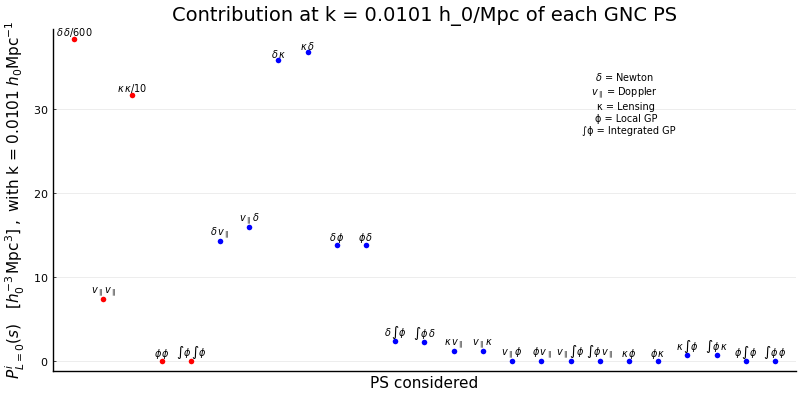

In [43]:
names = [
    L"\delta \, \delta / 600", 
    L"v_{\parallel} \, v_{\parallel}", 
    L"\kappa \, \kappa / 10", 
    L"\phi \, \phi", 
    L"\int\phi \, \int\phi", 
    
    L"\delta \, v_{\parallel}", L"v_{\parallel} \, \delta",
    L"\delta \, \kappa", L"\kappa \, \delta",
    L"\delta \, \phi", L"\phi \, \delta",
    L"\delta \, \int\phi", L"\int\phi \, \delta",
    
    L"\kappa \, v_{\parallel}", L"v_{\parallel} \, \kappa",
    L"v_{\parallel} \, \phi", L"\phi \, v_{\parallel}",
    L"v_{\parallel} \, \int\phi", L"\int\phi \, v_{\parallel}",
    
    L"\kappa \, \phi", L"\phi \, \kappa",
    L"\kappa \, \int\phi", L"\int\phi \, \kappa",
    
    L"\phi \, \int\phi", L"\int\phi \, \phi"
];
leg = L"\delta"*" = Newton    \n"*L"v_{\parallel}"*" = Doppler    \n" *
        "κ = Lensing  \n"*"ϕ = Local GP  \n"*"∫ϕ = Integrated GP"

pyplot()

k = 1e-2
index_real_k = findfirst(x -> x>k, ks_GNC_L0_withF_noobsvel)
real_k = ks_GNC_L0_withF_noobsvel[index_real_k]
ys = [begin
    num = pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC[effect]][index_real_k]
    i==1 ? num/600.0 : i==3 ? num/10 : num
    end    for (i,effect) in enumerate(GaPSE.GR_EFFECTS_GNC)];

plot(1:25, abs.(ys), seriestype=:scatter, 
    series_annotations = [text(name; pointsize=7, valign=:bottom) 
        for name in names], 
    mc=vcat([:red for i in 1:5], [:blue for i in 6:25]), 
    markerstrokewidth = 0, legend=false,
    xlabel = "PS considered",  xticks=false, size = (800, 400),
    ylabel = L"P^{i}_{L=0}(s) \quad [h_0^{-3}\,\mathrm{Mpc}^{3}]\; ," * 
    " with k = "* @sprintf("%.4f", real_k) * L"\; h_0\mathrm{Mpc}^{-1}",
    #ylims = (-1.10, 0.61), yticks = -1.0:0.25:0.5,
    title = "Contribution at k = " * @sprintf("%.4f", real_k) * " h_0/Mpc of each GNC PS"
    
)

#annotate!([(12, 250, text(leg; pointsize=7))])
annotate!([(20, 0.8*max(ys...), text(leg; pointsize=7))])

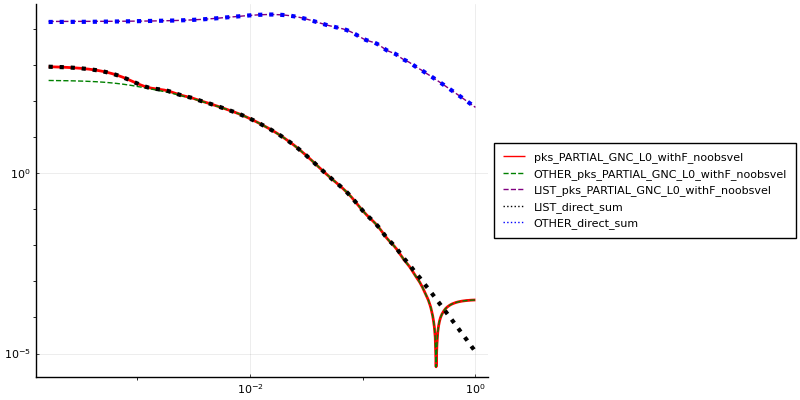

In [44]:
LIST_direct_sum = zeros(length(ks_GNC_L0_withF_noobsvel))
for effect in GaPSE.GR_EFFECTS_GNC
    if effect in LIST_GNC_SECURE
        nothing
    else
        LIST_direct_sum .+= pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC[effect]]
    end
end

OTHER_direct_sum = zeros(length(ks_GNC_L0_withF_noobsvel))
for effect in GaPSE.GR_EFFECTS_GNC
    if effect in LIST_GNC_SECURE
        OTHER_direct_sum .+= pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC[effect]]
    end
end


LIST_pks_PARTIAL_GNC_L0_withF_noobsvel = pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]] .+
    pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+
    pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]] .+
    pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]] .+
    pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["doppler_newton"]] .+
    pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["newton_doppler"]] .+
    pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["doppler_lensing"]] .+
    pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["lensing_doppler"]]
OTHER_pks_PARTIAL_GNC_L0_withF_noobsvel = pks_sum_GNC_L0_withF_noobsvel .-  LIST_pks_PARTIAL_GNC_L0_withF_noobsvel

plot(ks_GNC_L0_withF_noobsvel, abs.(pks_PARTIAL_GNC_L0_withF_noobsvel), label="pks_PARTIAL_GNC_L0_withF_noobsvel", 
    legend = :outerright, lw=2, lc=:red, axis=:log, size=(800, 400))
plot!(ks_GNC_L0_withF_noobsvel, abs.(OTHER_pks_PARTIAL_GNC_L0_withF_noobsvel), label="OTHER_pks_PARTIAL_GNC_L0_withF_noobsvel", 
    lw=1, lc=:green, ls=:dash)
plot!(ks_GNC_L0_withF_noobsvel, abs.(LIST_pks_PARTIAL_GNC_L0_withF_noobsvel), label="LIST_pks_PARTIAL_GNC_L0_withF_noobsvel", 
    lw=1, lc=:purple, ls=:dash)
plot!(ks_GNC_L0_withF_noobsvel, abs.(LIST_direct_sum), label="LIST_direct_sum", lw=3, lc=:black, ls=:dot)
plot!(ks_GNC_L0_withF_noobsvel, abs.(OTHER_direct_sum), label="OTHER_direct_sum", lw=3, lc=:blue, ls=:dot)

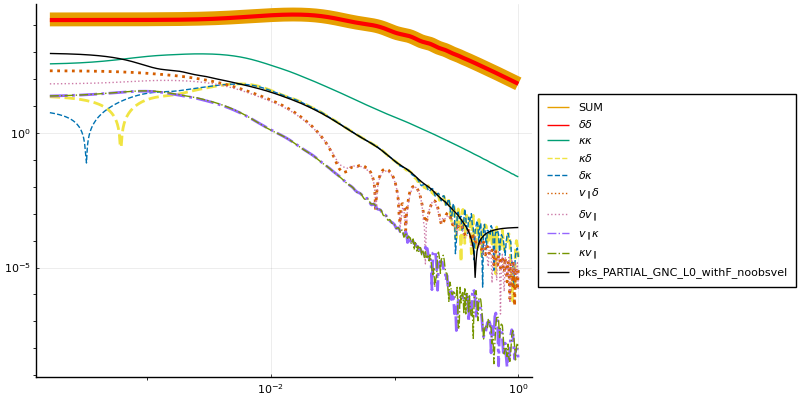

In [45]:
p = plot(
    ks_GNC_L0_withF_noobsvel, abs.(pks_sum_GNC_L0_withF_noobsvel), 
    axis=:log, label="SUM", lw=10, legend=:outerright, size=(800, 400))

plot!(p, ks_GNC_L0_withF_noobsvel, 
    abs.(pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]]),
    label=L"\delta\delta", lw = 3, lc = :red)
plot!(p, ks_GNC_L0_withF_noobsvel, 
    abs.(pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]]), 
    label=L"\kappa\kappa")
plot!(p, ks_GNC_L0_withF_noobsvel, 
    abs.(pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]]), 
    label=L"\kappa\delta", ls=:dash, lw=2)
plot!(p, ks_GNC_L0_withF_noobsvel, 
    abs.(pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]]), 
    label=L"\delta\kappa", ls=:dash)
plot!(p, ks_GNC_L0_withF_noobsvel, 
    abs.(pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["doppler_newton"]]), 
    label=L"v_{\parallel} \delta", ls=:dot, lw=2)
plot!(p, ks_GNC_L0_withF_noobsvel, 
    abs.(pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["newton_doppler"]]), 
    label=L"\delta v_{\parallel}", ls=:dot)
plot!(p, ks_GNC_L0_withF_noobsvel, 
    abs.(pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["doppler_lensing"]]), 
    label=L"v_{\parallel} \kappa", ls=:dashdot, lw=2)
plot!(p, ks_GNC_L0_withF_noobsvel, 
    abs.(pks_all_GNC_L0_withF_noobsvel[GaPSE.INDEX_GR_EFFECT_GNC["lensing_doppler"]]), 
    label=L"\kappa v_{\parallel}", ls=:dashdot)
plot!(p, ks_GNC_L0_withF_noobsvel, 
    abs.(pks_PARTIAL_GNC_L0_withF_noobsvel), label="pks_PARTIAL_GNC_L0_withF_noobsvel", ls=:solid, lc = :black)

## TPCFs and PS of the Galaxies in the Plain-Parallel Approximation

### Code for TPCFs and PS of PP

In [46]:
GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, DIR*"xi_ppg_L0_noF.dat",
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 0, use_windows = false, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, DIR*"xi_ppg_L2_noF.dat",
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 2, use_windows = false, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_PS_multipole(DIR*"xi_ppg_L0_noF.dat", 
    DIR*"ps_ppg_L0_noF.dat"; L = 0, ps_kwargs(tf)...);
GaPSE.print_PS_multipole(DIR*"xi_ppg_L2_noF.dat", 
    DIR*"ps_ppg_L2_noF.dat"; L = 2, ps_kwargs(tf)...);


time needed for map_ξ_PPGalaxies_multipole [in s] = 0.05067 

time needed for map_ξ_PPGalaxies_multipole [in s] = 0.05135 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.001764059066772461


I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0005629062652587891



In [47]:
ss_ppg_L0_noF, xis_ppg_L0_noF = GaPSE.readxy(DIR*"xi_ppg_L0_noF.dat");
ss_ppg_L2_noF, xis_ppg_L2_noF = GaPSE.readxy(DIR*"xi_ppg_L2_noF.dat");
ks_ppg_L0_noF, pks_ppg_L0_noF = GaPSE.readxy(DIR*"ps_ppg_L0_noF.dat");
ks_ppg_L2_noF, pks_ppg_L2_noF = GaPSE.readxy(DIR*"ps_ppg_L2_noF.dat");

spline_ppg_xis_L0_noF = Spline1D(ss_ppg_L0_noF, xis_ppg_L0_noF; bc = "error");
spline_ppg_xis_L2_noF = Spline1D(ss_ppg_L2_noF, xis_ppg_L2_noF; bc = "error");
spline_ppg_pks_L0_noF = Spline1D(ks_ppg_L0_noF, pks_ppg_L0_noF; bc = "error");
spline_ppg_pks_L2_noF = Spline1D(ks_ppg_L2_noF, pks_ppg_L2_noF; bc = "error");

In [48]:
GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, DIR*"xi_ppg_L0_withF.dat",
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 0, use_windows = true, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_map_ξ_PPGalaxies_multipole(cosmo, DIR*"xi_ppg_L2_withF.dat",
    10 .^ range(0,log10(2*cosmo.s_max),length=500);
    L = 2, use_windows = true, pr = true, enhancer = 1e6,
    atol_quad = 0.0, rtol_quad = 1e-2);
GaPSE.print_PS_multipole(DIR*"xi_ppg_L0_withF.dat", 
    DIR*"ps_ppg_L0_withF.dat"; L = 0, ps_kwargs(tf)...);
GaPSE.print_PS_multipole(DIR*"xi_ppg_L2_withF.dat", 
    DIR*"ps_ppg_L2_withF.dat"; L = 2, ps_kwargs(tf)...);

PP Galaxies, L=0: 100%|█████████████████████████████████| Time: 0:00:03



time needed for map_ξ_PPGalaxies_multipole [in s] = 3.54936 


PP Galaxies, L=2: 100%|█████████████████████████████████| Time: 0:00:02



time needed for map_ξ_PPGalaxies_multipole [in s] = 2.71907 

I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0006558895111083984


I'm computing the PS_multipole from the two input vectors.

time needed for this Power Spectrum computation [in s] = 0.0006148815155029297



In [49]:
ss_ppg_L0_withF, xis_ppg_L0_withF = GaPSE.readxy(DIR*"xi_ppg_L0_withF.dat");
ss_ppg_L2_withF, xis_ppg_L2_withF = GaPSE.readxy(DIR*"xi_ppg_L2_withF.dat");
ks_ppg_L0_withF, pks_ppg_L0_withF = GaPSE.readxy(DIR*"ps_ppg_L0_withF.dat");
ks_ppg_L2_withF, pks_ppg_L2_withF = GaPSE.readxy(DIR*"ps_ppg_L2_withF.dat");

spline_ppg_xis_L0_withF = Spline1D(ss_ppg_L0_withF, xis_ppg_L0_withF; bc = "error");
spline_ppg_xis_L2_withF = Spline1D(ss_ppg_L2_withF, xis_ppg_L2_withF; bc = "error");
spline_ppg_pks_L0_withF = Spline1D(ks_ppg_L0_withF, pks_ppg_L0_withF; bc = "error");
spline_ppg_pks_L2_withF = Spline1D(ks_ppg_L2_withF, pks_ppg_L2_withF; bc = "error");

### Check Plots on PP TPCFs and PS

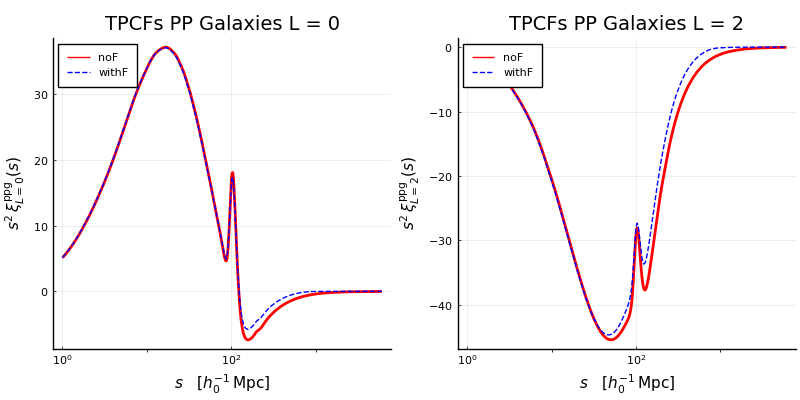

In [50]:
pyplot()
ps = [plot() for i in 1:2]

#title = plot(title = "PP TPCFs, L = 0 and 2, with and without F", grid=false, 
#    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

legend_pos=[
    :bottomleft,
    :bottomleft, :topright, :bottomleft, :bottomleft,
    :topleft, :topleft, :topleft, :topleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]

ps[1] = plot(
    ss_ppg_L0_noF, xis_ppg_L0_noF .* ss_ppg_L0_noF .^2, 
    lw=2, lc="red", ls=:solid, label = "noF",
    title="TPCFs PP Galaxies L = 0", size=(300, 100), 
    xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
    ylabel=L"s^2 \, \xi^{\mathrm{ppg}}_{L=0}(s)",
    xaxis=:log, #yaxis=:log,
    top_margins=15Plots.px, legend=:topleft)
plot!(ps[1],
    ss_ppg_L0_withF, xis_ppg_L0_withF .* ss_ppg_L0_withF .^2, 
    lw=1, lc="blue", ls=:dash, label = "withF",)

ps[2] = plot(
    ss_ppg_L2_noF, xis_ppg_L2_noF .* ss_ppg_L2_noF .^2, 
    lw=2, lc="red", ls=:solid, label = "noF",
    title="TPCFs PP Galaxies L = 2", size=(300, 100), 
    xlabel=L"s \quad [h_0^{-1}\,\mathrm{Mpc}]",
    ylabel=L"s^2 \, \xi^{\mathrm{ppg}}_{L=2}(s)",
    xaxis=:log, #yaxis=:log,
    top_margins=15Plots.px, legend=:topleft)
plot!(ps[2],
    ss_ppg_L2_withF, xis_ppg_L2_withF .* ss_ppg_L2_withF .^2, 
    lw=1, lc="blue", ls=:dash, label = "withF",)

P = plot(ps..., layout=grid(1,2), 
    #left_margins = 15Plots.px, right_margins = 30Plots.px,
    size=(800, 400));
P

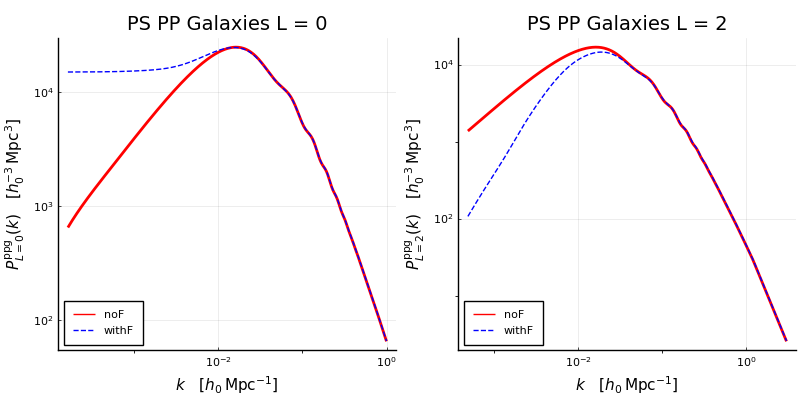

In [51]:
pyplot()
ps = [plot() for i in 1:2]

#title = plot(title = "PP TPCFs, L = 0 and 2, with and without F", grid=false, 
#    showaxis = false, bottom_margin = -50Plots.px, ticks=false)

legend_pos=[
    :bottomleft,
    :bottomleft, :topright, :bottomleft, :bottomleft,
    :topleft, :topleft, :topleft, :topleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
    :bottomleft, :bottomleft, :bottomleft, :bottomleft,
]

ps[1] = plot(
    ks_ppg_L0_noF[pks_ppg_L0_noF.≠0], abs.(pks_ppg_L0_noF)[pks_ppg_L0_noF.≠0], 
    lw=2, lc="red", ls=:solid, label = "noF",
    title="PS PP Galaxies L = 0", size=(300, 100), 
    xlabel=L"k \quad [h_0\,\mathrm{Mpc}^{-1}]",
    ylabel=L"P^{\mathrm{ppg}}_{L=0}(k) \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    xaxis=:log, yaxis=:log,
    top_margins=15Plots.px, legend=:bottomleft)
plot!(ps[1],
    ks_ppg_L0_withF[pks_ppg_L0_withF.≠0], abs.(pks_ppg_L0_withF)[pks_ppg_L0_withF.≠0], 
    lw=1, lc="blue", ls=:dash, label = "withF",)

ps[2] = plot(
    ks_ppg_L2_noF[pks_ppg_L2_noF.≠0], abs.(pks_ppg_L2_noF)[pks_ppg_L2_noF.≠0], 
    lw=2, lc="red", ls=:solid, label = "noF",
    title="PS PP Galaxies L = 2", size=(300, 100), 
    xlabel=L"k \quad [h_0\,\mathrm{Mpc}^{-1}]",
    ylabel=L"P^{\mathrm{ppg}}_{L=2}(k) \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    xaxis=:log, yaxis=:log,
    top_margins=15Plots.px, legend=:bottomleft)
plot!(ps[2],
    ks_ppg_L2_withF[pks_ppg_L2_withF.≠0], abs.(pks_ppg_L2_withF)[pks_ppg_L2_withF.≠0], 
    lw=1, lc="blue", ls=:dash, label = "withF",)

P = plot(ps..., layout=grid(1,2), 
    #left_margins = 15Plots.px, right_margins = 30Plots.px,
    size=(800, 400));
P

## Code for the differences: Newtonian - PPG , GNCsum - Newtonian , GNCsum - PPG

In [52]:
ks = ks_GNC_L0_withF_noobsvel;
diff_Newt_ppg =  [spline_Newt_pks_L0_withF_noobsvel(k) - spline_ppg_pks_L0_noF(k) for k in ks];
#diff_ALLGRsum_ppg = pks_ALLGRsum_L0_withF .- pks_ppg_L0_withF;
#diff_ALLGRsum_Newt = pks_ALLGRsum_L0_withF .- pks_Newtonian_L0_withF_noobsvel;
diff_GNCsum_ppg = [spline_GNCsum_pks_L0_withF_noobsvel(k) - spline_ppg_pks_L0_withF(k) for k in ks];
diff_GNCsum_Newt = [spline_GNCsum_pks_L0_withF_noobsvel(k) - spline_Newt_pks_L0_withF_noobsvel(k) for k in ks];

## Cross check Plots GNCsum-Newt-PPGalaxies

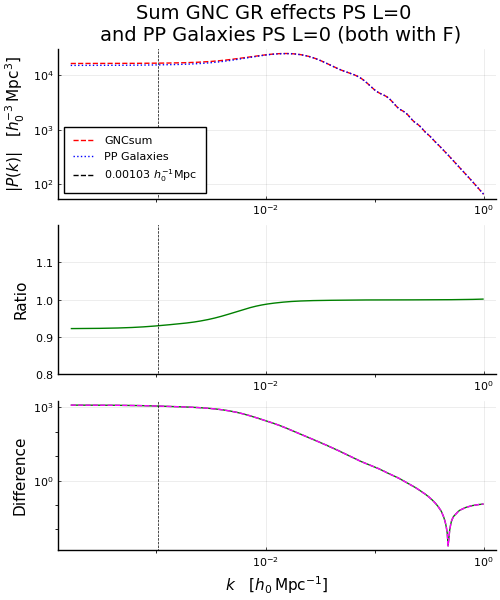

In [53]:
xs_1 = ks
ys_1 = spline_GNCsum_pks_L0_withF_noobsvel.(ks)

xs_2 = ks
ys_2 = spline_ppg_pks_L0_withF.(ks)
spline = Spline1D(xs_2, ys_2)

xs_3 = ks
ys_3 = diff_GNCsum_ppg

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GNC GR effects PS L=0 \n and PP Galaxies PS L=0 (both with F)",
    label=["GNCsum" "PP Galaxies"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log,
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_L0_GNCsum-PPGalaxies_withF.pdf")
#display(P)

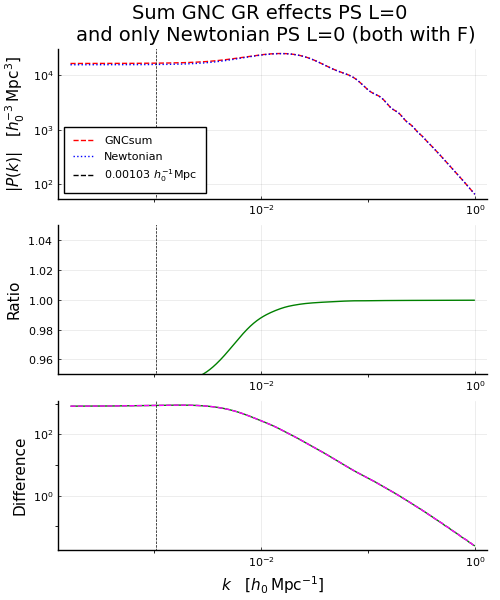

In [54]:
xs_1 = ks
ys_1 = spline_GNCsum_pks_L0_withF_noobsvel.(ks)

xs_2 = ks
ys_2 = spline_Newt_pks_L0_withF_noobsvel.(ks)
spline = Spline1D(xs_2, ys_2)

xs_3 = ks
ys_3 = diff_GNCsum_Newt

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "Sum GNC GR effects PS L=0 \n and only Newtonian PS L=0 (both with F)",
    label=["GNCsum" "Newtonian"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.95,1.05), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log, 
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_L0_GNCsum-Newton_withF.pdf")
#display(P)

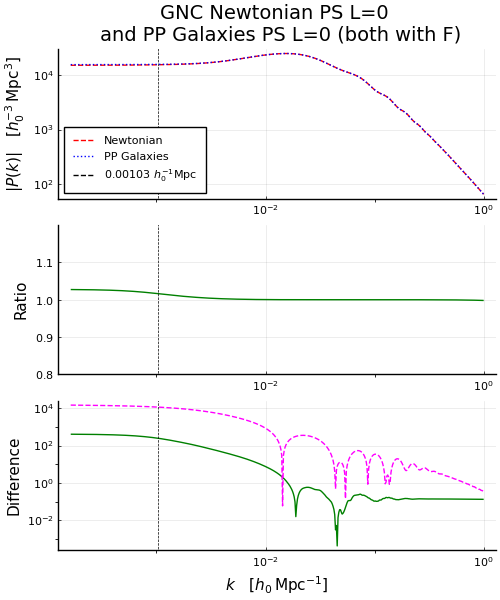

In [55]:
xs_1 = ks
ys_1 = spline_ppg_pks_L0_withF.(ks)

xs_2 = ks
ys_2 = spline_Newt_pks_L0_withF_noobsvel.(ks)
spline = Spline1D(xs_2, ys_2)


xs_3 = ks
ys_3 = diff_Newt_ppg

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot([xs_1, xs_2], [abs.(ys_1), abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], yticks = 10.0 .^ [i for i in 2:5],
    title = "GNC Newtonian PS L=0 \n and PP Galaxies PS L=0 (both with F)",
    label=["Newtonian" "PP Galaxies"], ls=[:dash :dot], 
    ylabel = L"|P(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:bottomleft)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    ylim=(0.8,1.2), 
    legend=false, 
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:black, lw=0.5, ls=:dash)

p3 = plot(xs_1, abs.(spline.(xs_1) .- ys_1), 
    ylabel="Difference", lc=:green, 
    axis=:log,
    #ylim=(0.0,2), 
    legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_3), lc=:magenta, ls=:dash)
VAXES = 4e-3
vline!(p3, [S_VLIM], label="$VAXES Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

P = plot(p1, p2, p3, size=(500, 600), layout= @layout [ x ; y ; z ] )
#savefig(P, DIR*"PS_L0_Newton-PPGalaxies_withF.pdf")
#display(P)

## RESULTS

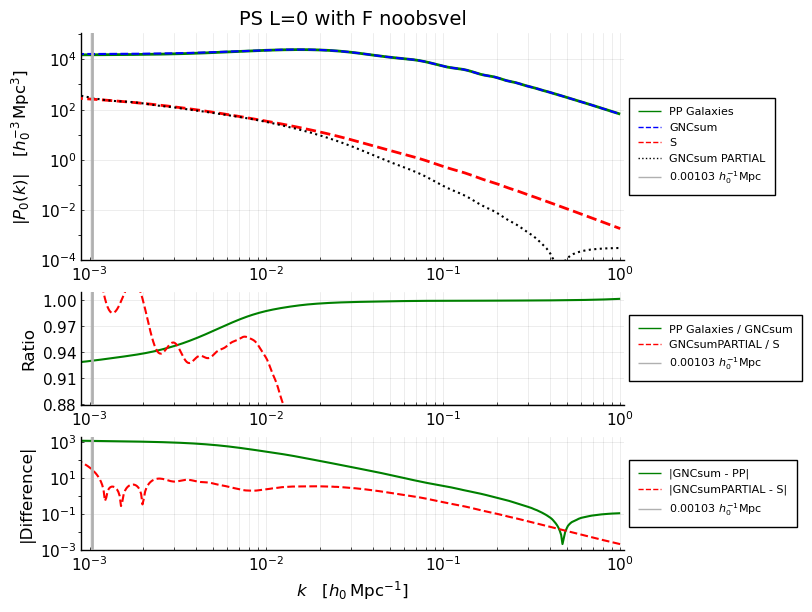

"/Users/di75tom/AAA_TESI_MAGISTRALE/GaPSE/ipynbs/ARTICLE/RESULTS_PS_L0_withF.pdf"

In [56]:
TICKFONTSIZE, LABELFONTSIZE = 11, 12;

KS = ks

xs_1 = KS
ys_1 = spline_ppg_pks_L0_withF.(KS)

xs_2 = KS
ys_2 = spline_GNCsum_pks_L0_withF_noobsvel.(KS)

xs_3 = KS
ys_3 = spline_S_pks_L0_withF.(KS)

xs_4 = KS
ys_4 = spline_GNCsumPARTIAL_pks_L0_withF_noobsvel.(KS)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(
    xs_1[ys_1.≠0], abs.(ys_1)[ys_1.≠0],
    axis=:log, lc=:green, ls=:solid, lw=2.0,
    yticks = 10.0 .^ [i for i in -6:2:6], ylims = (1e-4, 1.1e5),
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    title = "PS L=0 with F noobsvel",
    label="PP Galaxies",  tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    ylabel = L"|P_0(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:outerright)
plot!(p1, xs_2, abs.(ys_2), label="GNCsum", lc=:blue, ls=:dash, lw=1.5)
plot!(p1, xs_3, abs.(ys_3), label="S", lc=:red, ls=:dash, lw=2.0)
plot!(p1, xs_4, abs.(ys_4), label="GNCsum PARTIAL", lc=:black, ls=:dot, lw=1.5)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p2 = plot(xs_1, ys_1 ./ ys_2, 
    ylabel="Ratio", xaxis=:log, 
    ylim=(0.879,1.01), label="PP Galaxies / GNCsum",
    yticks=[i for i in 0.88:0.03:1],
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    legend=:outerright, tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    lc=:green, ls=:solid, lw=1.5
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, ys_4 ./ ys_3, label="GNCsumPARTIAL / S",
    lc=:red, ls=:dash, lw=1.5)
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p3 = plot(xs_1, abs.(ys_1 .- ys_2), 
    ylabel="|Difference|",  lc=:green, ls = :solid, lw=1.5,
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    yticks = 10.0 .^ [i for i in -3:2:3], ylim=(1e-3, 2e3),
    axis=:log, legend=:outerright, label = "|GNCsum - PP|",
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_4 .- ys_3), lc=:red, ls = :dash, lw=1.5, label = "|GNCsumPARTIAL - S|")
vline!(p3, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

P2 = plot(p1, p2, p3, size=(800, 600), layout= @layout [ x{0.5h} ; y ; z ] )
savefig(P2,  DIR*"RESULTS_PS_L0_withF.pdf")
#display(P)

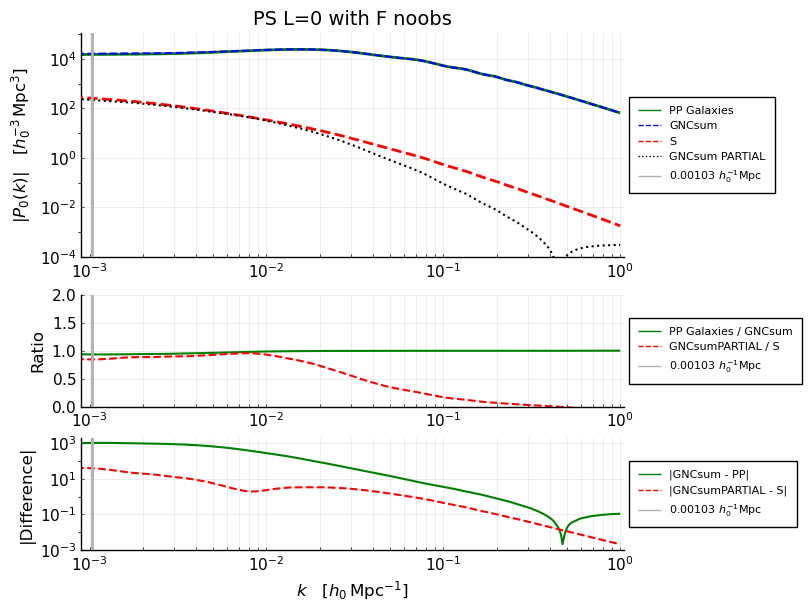

"/Users/di75tom/AAA_TESI_MAGISTRALE/GaPSE/ipynbs/ARTICLE/RESULTS_PS_L0_withF_noobs.pdf"

In [57]:
TICKFONTSIZE, LABELFONTSIZE = 11, 12;

KS = ks

xs_1 = KS
ys_1 = spline_ppg_pks_L0_withF.(KS)

xs_2 = KS
ys_2 = spline_GNCsum_pks_L0_withF_noobs.(KS)

xs_3 = KS
ys_3 = spline_S_pks_L0_withF.(KS)

xs_4 = KS
ys_4 = spline_GNCsumPARTIAL_pks_L0_withF_noobs.(KS)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(
    xs_1[ys_1.≠0], abs.(ys_1)[ys_1.≠0],
    axis=:log, lc=:green, ls=:solid, lw=2.0,
    yticks = 10.0 .^ [i for i in -6:2:6], ylims = (1e-4, 1.1e5),
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    title = "PS L=0 with F noobs",
    label="PP Galaxies",  tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    ylabel = L"|P_0(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:outerright)
plot!(p1, xs_2, abs.(ys_2), label="GNCsum", lc=:blue, ls=:dash, lw=1.5)
plot!(p1, xs_3, abs.(ys_3), label="S", lc=:red, ls=:dash, lw=2.0)
plot!(p1, xs_4, abs.(ys_4), label="GNCsum PARTIAL", lc=:black, ls=:dot, lw=1.5)
vline!(p1, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p2 = plot(xs_1, ys_1 ./ ys_2, 
    ylabel="Ratio", xaxis=:log, 
    ylim=(0,2), label="PP Galaxies / GNCsum",
    #yticks=[i for i in 0.88:0.03:1],
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    legend=:outerright, tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    lc=:green, ls=:solid, lw=1.5
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
plot!(p2, xs_1, ys_4 ./ ys_3, label="GNCsumPARTIAL / S",
    lc=:red, ls=:dash, lw=1.5)
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p3 = plot(xs_1, abs.(ys_1 .- ys_2), 
    ylabel="|Difference|",  lc=:green, ls = :solid, lw=1.5,
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    yticks = 10.0 .^ [i for i in -3:2:3], ylim=(1e-3, 2e3),
    axis=:log, legend=:outerright, label = "|GNCsum - PP|",
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
plot!(p3, xs_3, abs.(ys_4 .- ys_3), lc=:red, ls = :dash, lw=1.5, label = "|GNCsumPARTIAL - S|")
vline!(p3, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

P2 = plot(p1, p2, p3, size=(800, 600), layout= @layout [ x{0.5h} ; y ; z ] )
savefig(P2,  DIR*"RESULTS_PS_L0_withF_noobs.pdf")
#display(P)

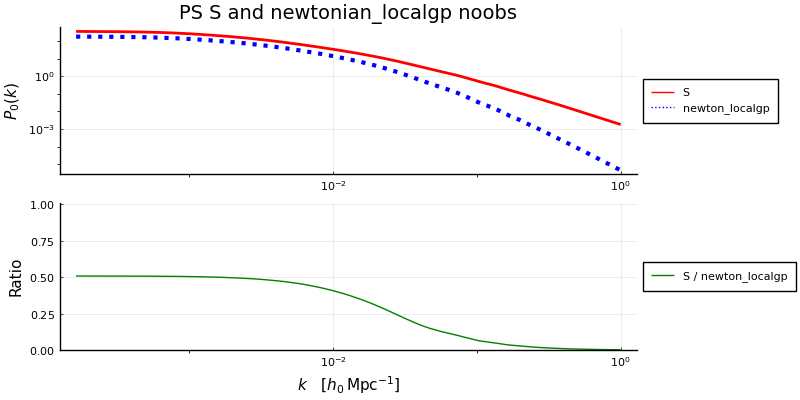

In [58]:
xs_1 = ks_GNC_L0_withF_noobs
ys_1 = spline_S_pks_L0_withF.(xs_1)

xs_2 = ks_GNC_L0_withF_noobs
ys_2 = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["newton_localgp"]]
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, abs.(xs_2)], [ys_1, abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS S and newtonian_localgp noobs", lw=[2 3],
    label=["S" "newton_localgp"], ls=[:solid :dot], 
    ylabel = L"P_0(k)",
    legend=:outerright)
#vline!(p1, [ss_S_L0_noF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
#vline!(p1, [ss_S_L0_noF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, ys_2 ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "S / newton_localgp",
    ylim=(0.,1.01), 
    legend=:outerright, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
#vline!(p2, [ss_S_L0_noF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
#vline!(p2, [ss_S_L0_noF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
    
P = plot(p1, p2, size=(800, 400), layout= @layout [ x ; y  ] )
#savefig(P, "xi_S_L2_noF.pdf");

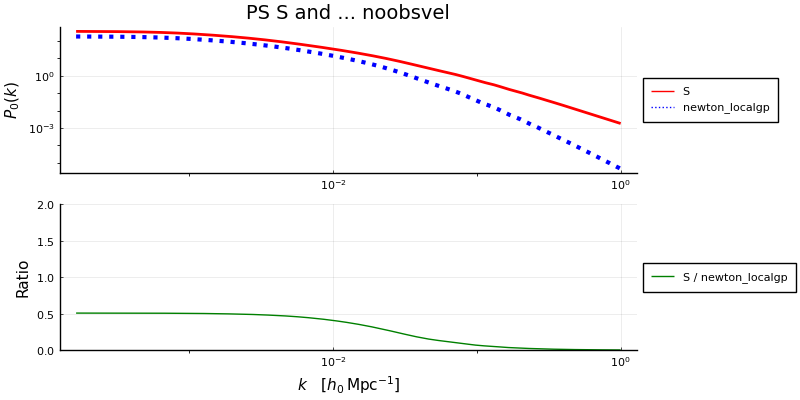

In [59]:
xs_1 = ks_GNC_L0_withF_noobs
ys_1 = spline_S_pks_L0_withF.(xs_1)

xs_2 = ks_GNC_L0_withF_noobs
#=
ys_2 = pks_sum_GNC_L0_withF_noobs .- (
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["auto_newton"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["auto_lensing"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["newton_lensing"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["lensing_newton"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["doppler_newton"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["newton_doppler"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["doppler_lensing"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["lensing_doppler"]]
    )
=#
ys_2 = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["newton_localgp"]]

spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, abs.(xs_2)], [ys_1, abs.(ys_2)],
    xaxis=:log, yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "PS S and ... noobsvel", lw=[2 3],
    label=["S" "newton_localgp"], ls=[:solid :dot], 
    ylabel = L"P_0(k)",
    legend=:outerright)
#vline!(p1, [ss_S_L0_noF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
#vline!(p1, [ss_S_L0_noF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, abs.(ys_2 ./ ys_1), 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "S / newton_localgp",
    ylim=(0.,2), 
    legend=:outerright, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
#vline!(p2, [ss_S_L0_noF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
#vline!(p2, [ss_S_L0_noF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
    
P = plot(p1, p2, size=(800, 400), layout= @layout [ x ; y  ] )
#savefig(P, "xi_S_L2_noF.pdf");

## Write in a file

In [60]:
open(DIR * "RESULTS.txt", "w") do io
    GaPSE.parameters_used(io, cosmo)
    println(io, "#\n#\n#")
    println(io, "# LIST = " * string(LIST_GNC_SECURE[begin:end-1] .* " + "...) * LIST_GNC_SECURE[end])
    println(io, "# k \t P_0^{ppg} \t P_0^{GNCsum} \t P_0^{S} \t P_0^{GNCsum - LIST}")
    for k in ks_GNC_L0_withF_noobsvel
        println(io, 
            "$k \t $(spline_ppg_pks_L0_withF(k)) \t $(spline_GNCsum_pks_L0_withF_noobsvel(k)) \t "*
            " $(spline_S_pks_L0_withF(k)) \t $(spline_GNCsumPARTIAL_pks_L0_withF_noobsvel(k)) "
        )
    end
end

## END

### Test on the PS FFTLog

In [61]:
ks_GNC_L0_withF_noobsvel[begin], ks_GNC_L0_withF_noobsvel[end]

(0.00016369382206909115, 1.0)

In [62]:
#=
TEST_name_ps_GNC_L0_withF_noobsvel_file = "TEST_ps_GNC_L0_withF_noobsvel.txt"

GaPSE.print_all_PS_multipole(DIR*name_xis_GNC_L0_withF_noobsvel_file, 
    DIR*TEST_name_ps_GNC_L0_withF_noobsvel_file, "GNC"; L=0, Dict(
        :alg => :fftlog, :pr=>true, :ν => 1.5, 
        :n_extrap_low => 0, :n_extrap_high => 0, 
        :n_pad => 0, :cut_first_n=>0, :cut_last_n => 0,
    )...)
ks_GNC_L0_withF_noobsvel_TEST, pks_sum_GNC_L0_withF_noobsvel_TEST, pks_all_GNC_L0_withF_noobsvel_TEST = 
    GaPSE.readxyall(DIR*TEST_name_ps_GNC_L0_withF_noobsvel_file);

spline_TEST_GNCsum_pks_L0_withF = Spline1D(ks_GNC_L0_withF_noobsvel_TEST, pks_sum_GNC_L0_withF_noobsvel_TEST; bc = "error");

ks_GNC_L0_withF_noobsvel_TEST[begin], ks_GNC_L0_withF_noobsvel_TEST[end]
=#

In [63]:
#=
TICKFONTSIZE, LABELFONTSIZE = 11, 12;

KS = ks_GNC_L0_withF_noobsvel

xs_1 = KS
ys_1 = spline_GNCsum_pks_L0_withF_noobsvel.(KS)

xs_2 = KS
ys_2 = spline_TEST_GNCsum_pks_L0_withF.(KS)

S_VLIM = 2*π/(2*cosmo.s_max)
S_VLIM_F = @sprintf("%.5f", S_VLIM)

p1 = plot(
    xs_1[ys_1.≠0], abs.(ys_1)[ys_1.≠0],
    axis=:log, lc=:green, ls=:solid, lw=2.0,
    yticks = 10.0 .^ [i for i in 0:1:6], ylims = (1e1, 1.1e5),
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    title = "PS L=0 with F",
    label="GNCsum",  tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    ylabel = L"|P_0(k)| \quad [h_0^{-3}\,\mathrm{Mpc}^3]",
    legend=:outerright)
plot!(p1, xs_2, abs.(ys_2), label="TEST", lc=:blue, ls=:dash, lw=1.5)

p2 = plot(xs_1, ys_1 ./ ys_2, 
    ylabel="Ratio", xaxis=:log, 
    ylim=(0.879,1.01), 
    yticks=[i for i in 0.88:0.03:1],
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    legend=false, tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    lc=:green, ls=:solid, lw=1.5
    #xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$",
    )
vline!(p2, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

p3 = plot(xs_1, abs.(ys_1 .- ys_2), 
    ylabel="|Difference|",  lc=:green, ls = :solid, lw=1.5,
    xticks = (
        vcat([a*10.0^b for b in -3:(-1) for a in 1:9], 10.0^0), 
        vcat([a==1 ? L"10^{%$b}" : nothing for b in -3:(-1) for a in 1:9], L"10^{0}")
    ), xlims = (0.9e-3, 1.05e0),
    tickfontsize=TICKFONTSIZE, labelfontsize=LABELFONTSIZE,
    yticks = 10.0 .^ [i for i in -3:2:3], ylim=(1e-3, 2e3),
    axis=:log, legend=false, 
    xlabel=L"$k \quad [h_0 \,\mathrm{Mpc}^{-1}]$")
vline!(p3, [S_VLIM], label="$S_VLIM_F " * L" h_0^{-1}\mathrm{Mpc}", lc=:grey69, lw=2, ls=:solid)

P2 = plot(p1, p2, p3, size=(800, 600), layout= @layout [ x{0.5h} ; y ; z ] )
#savefig(P2,  DIR*"RESULTS_PS_L0_withF.pdf")
#display(P)
=#

### Test on the S TPCFs and PS

In [64]:
casto_ss, casto_vec = GaPSE.readxall("ARTICLE/table_bphiFNL1p0_b1p5_zeff1p26.dat"; comments=true)
casto_xis_S_L0_noF, casto_xis_S_L2_noF = casto_vec[1], casto_vec[2];

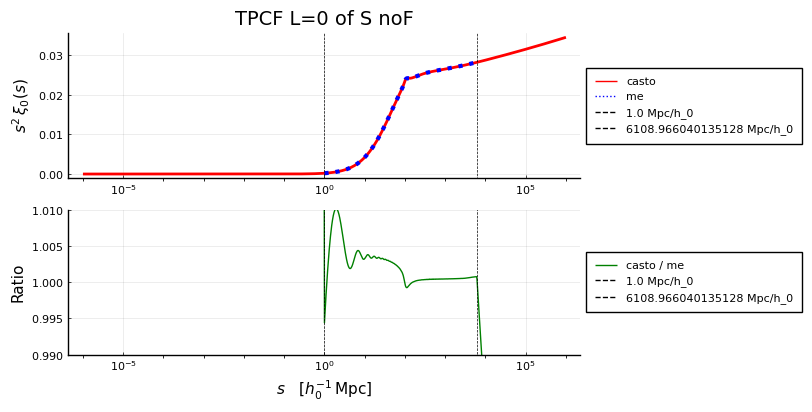

In [65]:
xs_1 = casto_ss
ys_1 = casto_xis_S_L0_noF .* xs_1 .^ 2

xs_2 = ss_S_L0_noF 
ys_2 = xis_S_L0_noF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "TPCF L=0 of S noF", lw=[2 3],
    label=["casto" "me"], ls=[:solid :dot], 
    ylabel = L"s^2 \, \xi_0(s)",
    legend=:outerright)
vline!(p1, [ss_S_L0_noF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
vline!(p1, [ss_S_L0_noF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "casto / me",
    ylim=(0.99,1.01), 
    legend=:outerright, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
vline!(p2, [ss_S_L0_noF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
vline!(p2, [ss_S_L0_noF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
    
P = plot(p1, p2, size=(800, 400), layout= @layout [ x ; y  ] )
savefig(P, "xi_S_L0_noF.pdf");

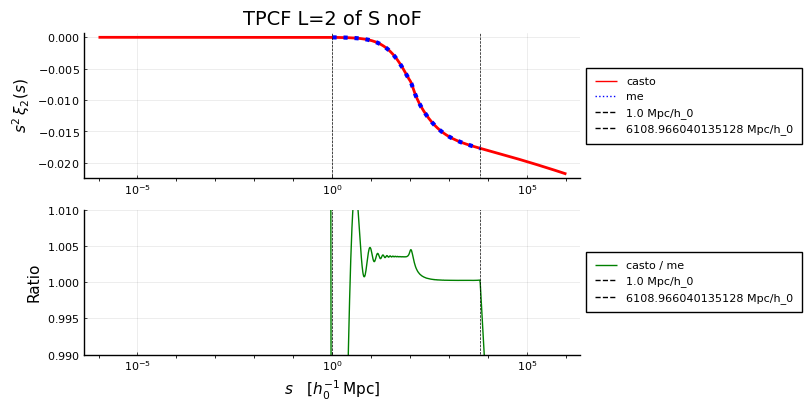

In [66]:
xs_1 = casto_ss
ys_1 = casto_xis_S_L2_noF .* xs_1 .^ 2

xs_2 = ss_S_L2_noF 
ys_2 = xis_S_L2_noF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "TPCF L=2 of S noF", lw=[2 3],
    label=["casto" "me"], ls=[:solid :dot], 
    ylabel = L"s^2 \, \xi_2(s)",
    legend=:outerright)
vline!(p1, [ss_S_L0_noF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
vline!(p1, [ss_S_L0_noF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "casto / me",
    ylim=(0.99,1.01), 
    legend=:outerright, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
vline!(p2, [ss_S_L0_noF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
vline!(p2, [ss_S_L0_noF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
    
P = plot(p1, p2, size=(800, 400), layout= @layout [ x ; y  ] )
savefig(P, "xi_S_L2_noF.pdf");

In [67]:
spline_casto_xi_S_L0_noF = Spline1D(casto_ss, casto_xis_S_L0_noF, bc="error");
spline_casto_xi_S_L2_noF = Spline1D(casto_ss, casto_xis_S_L2_noF, bc="error");
spline_casto_xi_S(s1, y) = spline_casto_xi_S_L0_noF(s1) + spline_casto_xi_S_L2_noF(s1) * Pl(y, 2);

In [68]:
function integrand_casto_xi_S_multipole(s, μ, cosmo::GaPSE.Cosmology; L::Int=0, use_windows::Bool=true)
    res = if use_windows == true
        spline_casto_xi_S(s, μ) .* (
            GaPSE.spline_integrF(s, μ, cosmo.windowFint) / cosmo.WFI_norm * Pl(μ, L)
        )
    else
        spline_casto_xi_S(s1, μ).* Pl(μ, L)
    end

    return (2.0 * L + 1.0) / 2.0 * res
end;

function casto_xi_S_multipole(s, cosmo::GaPSE.Cosmology;
     L::Int=0, use_windows::Bool=true,
     atol_quad::Float64=0.0, rtol_quad::Float64=1e-2, enhancer::Float64=1e6)

     orig_f(μ) = enhancer * integrand_casto_xi_S_multipole(s, μ, cosmo;
          L=L, use_windows=use_windows)

     int = quadgk(μ -> orig_f(μ), -1.0, 1.0; atol=atol_quad, rtol=rtol_quad)[1]

     return int / enhancer
end;

In [69]:
casto_xis_S_L0_withF = @showprogress "L=0" [casto_xi_S_multipole(s, cosmo; L=0, use_windows=true) for s in casto_ss];
casto_xis_S_L2_withF = @showprogress "L=2" [casto_xi_S_multipole(s, cosmo; L=2, use_windows=true) for s in casto_ss];

L=0 100%|████████████████████████████████████████████████| Time: 0:00:03
L=2 100%|████████████████████████████████████████████████| Time: 0:00:16


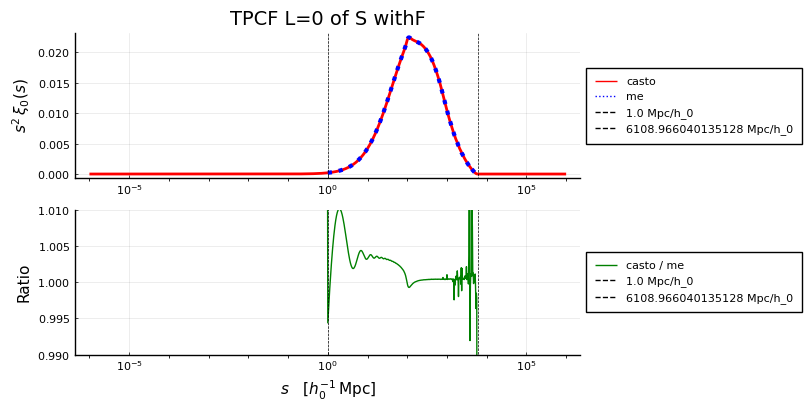

In [70]:
xs_1 = casto_ss
ys_1 = casto_xis_S_L0_withF .* xs_1 .^ 2

xs_2 = ss_S_L0_withF 
ys_2 = xis_S_L0_withF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "TPCF L=0 of S withF", lw=[2 3],
    label=["casto" "me"], ls=[:solid :dot], 
    ylabel = L"s^2 \, \xi_0(s)",
    legend=:outerright)
vline!(p1, [ss_S_L0_withF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
vline!(p1, [ss_S_L0_withF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "casto / me",
    ylim=(0.99,1.01), 
    legend=:outerright, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
vline!(p2, [ss_S_L0_withF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
vline!(p2, [ss_S_L0_withF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
    
P = plot(p1, p2, size=(800, 400), layout= @layout [ x ; y  ] )
savefig(P, "xi_S_L0_withF.pdf");

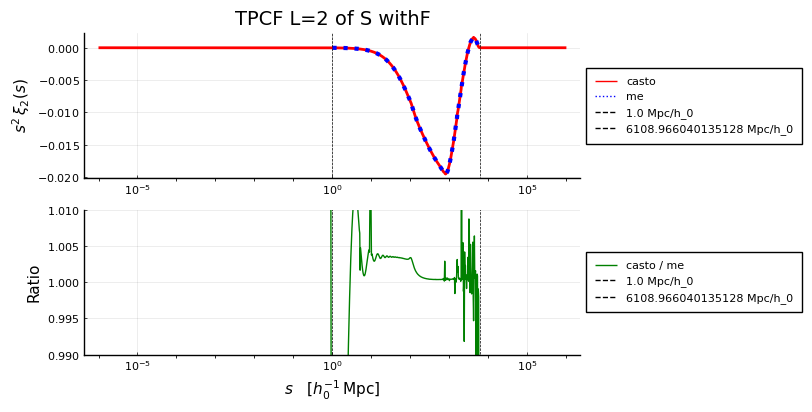

In [71]:
xs_1 = casto_ss
ys_1 = casto_xis_S_L2_withF .* xs_1 .^ 2

xs_2 = ss_S_L2_withF 
ys_2 = xis_S_L2_withF .* xs_2 .^ 2
spline = Spline1D(xs_2, ys_2)

p1 = plot([xs_1, xs_2], [ys_1, ys_2],
    xaxis=:log, #yaxis=:log, 
    lc=[:red :blue], #yticks = 10.0 .^ [i for i in 2:5],
    title = "TPCF L=2 of S withF", lw=[2 3],
    label=["casto" "me"], ls=[:solid :dot], 
    ylabel = L"s^2 \, \xi_2(s)",
    legend=:outerright)
vline!(p1, [ss_S_L0_withF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
vline!(p1, [ss_S_L0_withF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)

p2 = plot(xs_1, spline.(xs_1) ./ ys_1, 
    ylabel="Ratio", lc=:green, 
    xaxis=:log, 
    label = "casto / me",
    ylim=(0.99,1.01), 
    legend=:outerright, 
    xlabel=L"$s \quad [h_0^{-1} \,\mathrm{Mpc}]$",
    )
vline!(p2, [ss_S_L0_withF[begin]], label="$(ss_S_L0_withF[begin]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
vline!(p2, [ss_S_L0_withF[end]], label="$(ss_S_L0_withF[end]) Mpc/h_0", lc=:black, lw=0.5, ls=:dash)
    
P = plot(p1, p2, size=(800, 400), layout= @layout [ x ; y  ] )
savefig(P, "xi_S_L2_withF.pdf");

### Test ratio LIST GNC PS and S PS

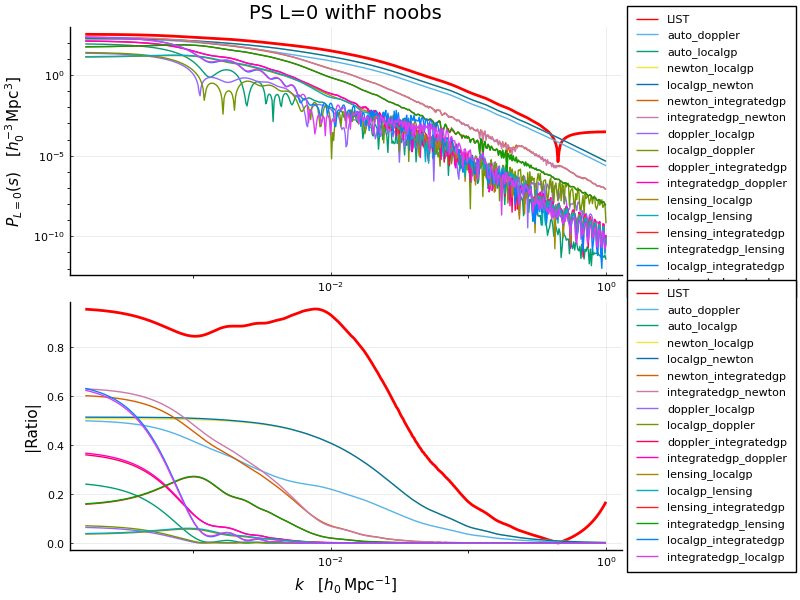

In [72]:
xs = ks_GNC_L0_withF_noobs
ys_S = spline_S_pks_L0_withF.(xs)

ys = pks_PARTIAL_GNC_L0_withF_noobs
p1 = plot(
    xs[ys.≠0], abs.(ys)[ys.≠0], 
    label="LIST", title="PS L=0 withF noobs", 
    ylabel=L"P_{L=0}(s)  \quad [h_0^{-3} \,\mathrm{Mpc}^3] ",
    legend = :outerright, lw=2, lc=:red, axis=:log, size=(800, 400))
for effect in LIST_GNC_NON_SECURE
    ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC[effect]]
    plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=effect)
end

ys = pks_PARTIAL_GNC_L0_withF_noobs
p2 = plot(xs, abs.(ys./ys_S), 
    xlabel=L"k \quad [h_0 \,\mathrm{Mpc}^{-1}]",
    ylabel="|Ratio|", label ="LIST",
    legend = :outerright, lw=2, lc=:red, xaxis=:log,
)

for effect in LIST_GNC_NON_SECURE
    ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC[effect]]
    plot!(p2, xs, abs.(ys./ys_S), label=effect)
end

plot(p1, p2, layout=grid(2,1), size=(800, 600))

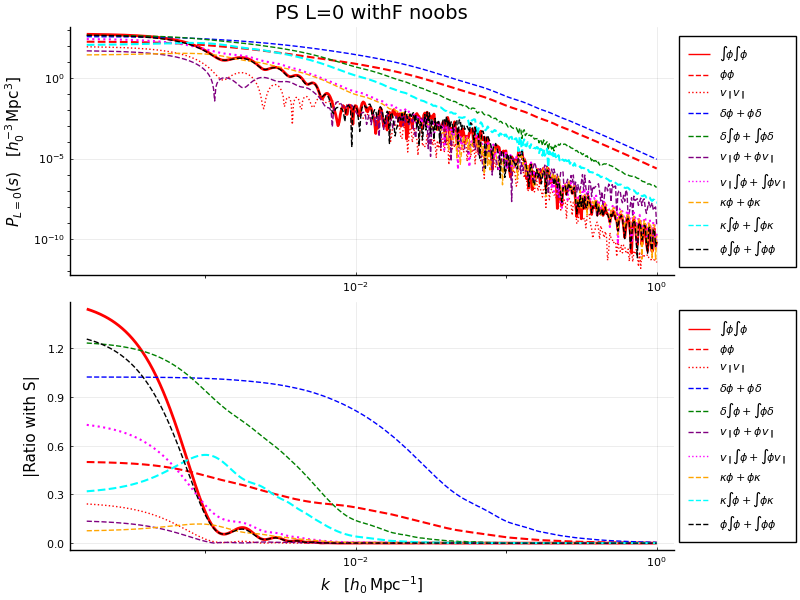

In [90]:
xs = ks_GNC_L0_withF_noobs
ys_S = spline_S_pks_L0_withF.(xs)

#=
ys = pks_PARTIAL_GNC_L0_withF_noobs
p1 = plot(
    xs[ys.≠0], abs.(ys)[ys.≠0], 
    label="LIST", title="PS L=0 withF noobs", 
    ylabel=L"P_{L=0}(s)  \quad [h_0^{-3} \,\mathrm{Mpc}^3] ",
    legend = :outerright, lw=2, lc=:BLACK, axis=:log, size=(800, 400))
=#
p1 = plot(title="PS L=0 withF noobs", 
    ylabel=L"P_{L=0}(s)  \quad [h_0^{-3} \,\mathrm{Mpc}^3] ",
    legend = :outerright, axis=:log, size=(800, 400))

ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["auto_integratedgp"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"\int\!\phi \int\!\phi", lw=2, lc=:red, ls=:solid)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["auto_doppler"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"\phi \phi", lw=1.5, lc=:red, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["auto_localgp"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"v_{\parallel} v_{\parallel}", lw=1, lc=:red, ls=:dot)

ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["newton_localgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["localgp_newton"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"\delta\phi + \phi\delta", 
    lw=1, lc=:blue, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["newton_integratedgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["integratedgp_newton"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"\delta\int\!\phi + \int\!\phi\delta", 
    lw=1, lc=:green, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["doppler_localgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["localgp_doppler"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"v_{\parallel}\phi + \phi v_{\parallel}", 
    lw=1, lc=:purple, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["doppler_integratedgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["integratedgp_doppler"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"v_{\parallel}\int\!\phi + \int\!\phi v_{\parallel}", 
    lw=1.5, lc=:magenta, ls=:dot)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["lensing_localgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["localgp_lensing"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"\kappa\phi + \phi \kappa", 
    lw=1, lc=:orange, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["lensing_integratedgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["integratedgp_lensing"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"\kappa\int\!\phi + \int\!\phi \kappa", 
    lw=1.5, lc=:cyan, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["localgp_integratedgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["integratedgp_localgp"]]
plot!(p1, xs[ys.≠0], abs.(ys)[ys.≠0], label=L"\phi\int\!\phi + \int\!\phi \phi", 
    lw=1.0, lc=:black, ls=:dash)
#=
ys = pks_PARTIAL_GNC_L0_withF_noobs
p2 = plot(xs, abs.(ys./ys_S), 
    xlabel=L"k \quad [h_0 \,\mathrm{Mpc}^{-1}]",
    ylabel="|Ratio with S|", label ="LIST",
    legend = :outerright, lw=2, lc=:red, xaxis=:log,
)
=#

p2 = plot(xlabel=L"k \quad [h_0 \,\mathrm{Mpc}^{-1}]",
    ylabel="|Ratio with S|", label ="LIST",
    legend = :outerright, lw=2, lc=:red, xaxis=:log,
)

ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["auto_integratedgp"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"\int\!\phi \int\!\phi", lw=2, lc=:red, ls=:solid)

ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["auto_doppler"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"\phi \phi", lw=1.5, lc=:red, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["auto_localgp"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"v_{\parallel} v_{\parallel}", lw=1, lc=:red, ls=:dot)

ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["newton_localgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["localgp_newton"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"\delta\phi + \phi\delta", 
    lw=1, lc=:blue, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["newton_integratedgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["integratedgp_newton"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"\delta\int\!\phi + \int\!\phi\delta", 
    lw=1, lc=:green, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["doppler_localgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["localgp_doppler"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"v_{\parallel}\phi + \phi v_{\parallel}", 
    lw=1, lc=:purple, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["doppler_integratedgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["integratedgp_doppler"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"v_{\parallel}\int\!\phi + \int\!\phi v_{\parallel}", 
    lw=1.5, lc=:magenta, ls=:dot)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["lensing_localgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["localgp_lensing"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"\kappa\phi + \phi \kappa", 
    lw=1, lc=:orange, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["lensing_integratedgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["integratedgp_lensing"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"\kappa\int\!\phi + \int\!\phi \kappa", 
    lw=1.5, lc=:cyan, ls=:dash)
ys = pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["localgp_integratedgp"]] .+
    pks_all_GNC_L0_withF_noobs[GaPSE.INDEX_GR_EFFECT_GNC["integratedgp_localgp"]]
plot!(p2, xs, abs.(ys./ys_S), label=L"\phi\int\!\phi + \int\!\phi \phi", 
    lw=1.0, lc=:black, ls=:dash)

plot(p1, p2, layout=grid(2,1), size=(800, 600))